## Schwarzschild orbit-superposition modelling

This approach for constructing equilibrium models was introduced by [Martin Schwarzschild in 1979](http://adsabs.harvard.edu/abs/1979ApJ...232..236S) (after his retirement!), as the first practical demonstration that triaxial equilibrium galaxy models may exist – at the time, it was not at all obvious!

Originally, the method was purely a theorist's tool, but soon it was extended to take into account observational constraints and became one of standard tools in dynamical modelling (inferring the mass distribution from kinematic data). At the same time, its theoretical applications include the construction of initial conditions for $N$-body simulations. In both theoretical and observational flavours, its advantages are the ability to handle complicated geometry of the model (axisymmetric, triaxial and even a rotating bar) and a very flexible representation of the distribution function – the latter can also be a drawback, in the sense that the resulting models may have unphysically rapid variations of the DF across the phase space. To mitigate this situation, some regularisation is needed, as with any non-parametric method.

In this tutorial, we first discuss the fundamental concepts of the orbit-superposition method and the particular features of its implementation in `Agama` – essentially, the "theoretical" flavour of the method. Observational applications will be considered in the second part of this tutorial. Since the method works with orbits, it is essential to first complete the `tutorial_potential_orbits` notebook.

### Outline

The model is composed of building blocks – individual orbits. Each orbit is a point (delta function) in the integrals of motion space, and its weight represents the density of stars in the vicinity of this point, thus the distribution function of the entire model is approximated by a weighted superposition of delta functions. Of course, to compute orbits, we need the gravitational potential and an array of initial conditions for the orbit library – it can be generated in different ways, what is important is that it covers the entire space of integrals of motion reasonably well. For the model to be in equilibrium, we need to ensure that the density generated by the weighted superposition of orbits matches the gravitational potential via the Poisson equation. And when fitting the model to observations, we also need to record the contribution of orbits to the kinematic maps and assign the orbit weights in such a way as to maximize the match between the observed kinematics and the weighted sum of each orbit's contribution.

So the ingredients in the model are the following:

- Gravitational potential of the entire system $\Phi_\text{total}$.
- Initial conditions for the orbit library (a 2d array of $N_\text{orbits}$ 6d phase-space points).
- Orbits computed from these initial conditions.
- Data stored during the orbit integration: contribution of each orbit to the density profile and to kinematic maps: $K$ matrices $\mathsf{D}^{(k)}$ of shape $N_\text{orbits} \times N_\text{constraints}^{(k)}$, where $k=1..K$ enumerates the datasets (typically one for the density, and zero or more for kinematics).
- Required values for the constraints ($K$ vectors $\boldsymbol{r}^{(k)}$ of length $N_\text{constraints}^{(k)}$) that need to be matched by the weighted orbit superposition.
- Weights $w_i$ associated with each orbit, $i=1..N_\text{orbits}$.

#### Mathematical formulation
The weights $\boldsymbol{w}$ are assigned by solving the following set of linear equations:<br>
$\mathsf{D}^{(k)}\, \boldsymbol{w} = \boldsymbol{r}^{(k)}\quad \big($or writing the indices explicitly, $\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D^{(k)}_{c,i}\, w_i = r^{(k)}_c \big)$;<br>
note that the vector of unknown weights $\boldsymbol{w}$ is the same for all datasets, so one can simplify the notation by considering only one dataset, and when using more than one, just stack the matrices $\mathsf{D}^{(k)}$ and right-hand-side vectors $\boldsymbol{r}^{(k)}$.

Of course, it is not *just* an ordinary linear equation system, because we require that weights are non-negative: $w_i\ge 0$. This is called a *linear programming* (or *optimization*) problem. In practice, however, we solve a *quadratic optimization* problem, for the reasons explained shortly. As the name implies, it optimizes (specifically, minimizes) a certain quantity, called *objective function* $\mathcal Q$, but what is this quantity?

Well, it turns out that the linear equation system may not always be possible to solve exactly, so we have to be satisfied with an approximate solution (e.g., in the least-square sense). Denote $\epsilon_c$ the uncertainties associated with the constraint values $r_c$; then the objective function is
$$ \mathcal Q = \sum\limits_{c=1}^{N_\text{constraints}} \left( \frac{\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D_{c,i}\, w_i - r_c}{\displaystyle \epsilon_c} \right)^2 . $$
Now this expression is a quadratic form in the vector of unknown weights, explaining the name.<br>
In practice, treating the constraints as inexact is appropriate for observational kinematic constraints, but for some other datasets (for instance, describing the density profile) we may still wish to satisfy the corresponding constraints exactly. So the general formulation of a quadratic optimization problem is the following: minimize the scalar objective function $\mathcal Q = \frac{1}{2} \boldsymbol{w}^T\,\mathsf{Q}\,\boldsymbol{w} + \boldsymbol c^T\boldsymbol w$ that is quadratic in $\boldsymbol w$ (like the above expression, but possibly with some other terms discussed later), subject to a set of equality constraints $\mathsf{A}\,\boldsymbol{w} = \boldsymbol{b}$ and inequality constraints $\boldsymbol w \ge 0$.

#### Implementation in Agama

As with other galactic dynamic applications, `Agama` provides basic tools for orbit-superposition modelling, leaving the detailed control of the workflow to the user.<br>
A minimal example of model construction can be implemented in a dozen lines of Python code, while creation of observationally-constrained models involves much more data manipulation and analysis. To facilitate the latter task, the `agama.schwarzlib` module provides another layer of classes and routines written in Python, which assist in exploring the parameter space for models and visualizing them in comparison to the observational data; it forms the `Forstand` code for Schwarzschild modelling ([Vasiliev&Valluri 2021](http://adsabs.harvard.edu/abs/2020ApJ...889...39V)).<br>
In addition to this tutorial, the repository contains a couple of example scripts for constructing "theoretical" orbit-superposition models: `example_schwarzschild_flattened_rotating.py`, `example_schwarzschild_triaxial.py` (in both cases, the model properties are hardcoded in the script itself), and a more general program `schwarzschild.py` that is configured by providing an INI file with model parameters. It largely replaces the earlier implementation of the Schwarzschild method known as `Smile` ([Vasiliev 2013](http://adsabs.harvard.edu/abs/2013MNRAS.434.3174V), [Vasiliev&Athanassoula 2015](http://adsabs.harvard.edu/abs/2015MNRAS.450.2842V)), although the interactive GUI of the SMILE code has no direct analogue in `Agama`.<br>
The observational flavour of the method is illustrated in `example_forstand.py`, which can serve as a template that needs to be adapted to specific galaxy modelling applications.

In [1]:
import agama, numpy, matplotlib, matplotlib.pyplot as plt
%matplotlib inline
plt.rc('figure', dpi=100)
plt.rc('font', size=10)
plt.rc('axes', linewidth=0.5)
plt.rc('mathtext', fontset='stix')

### Part 1: theoretical applications

The first part concerns the creation of models with prescribed properties (density profile and some basic kinematic features), without dealing with any observational constraints.

In this example, we consider a simple galaxy model consisting of a flattened cuspy spheroid profile for stars, plus a second component – a central supermassive black hole (BH) with mass 10% of stellar mass. It is straightforward to generalize the procedure to multiple dynamical components (e.g. stars and dark halo).

Each component is used in two contexts: as a density profile that needs to be assembled from orbits, and as a contribution to the total potential. To distinguish these two usages, we use two variables `dens_stars` and `pot_stars` referring to the same object. Note that in case of multiple density components, it is usually more efficient to combine all of them in the constructor of the total potential, rather than create separate potentials for each component, as explained in `tutorial_potential_orbits`.

In [2]:
q = 0.6  # axis ratio z/x
total_mass = 1.0
bh_mass = 0.1
pot_stars = agama.Potential(type='Spheroid', gamma=1, beta=5, mass=total_mass, scaleRadius=1, axisRatioZ=q)
dens_stars = pot_stars
pot_bh = agama.Potential(type='Plummer', mass=bh_mass, scaleRadius=0)
pot_total = pot_stars + pot_bh   # shorthand for  pot_total = agama.Potential(pot_stars, pot_bh)

#### Creating orbital initial conditions

We begin by creating ICs for the orbit library. <br>
A convenient choice is to sample positions from the density profile of the component, and assign velocities that are somewhat close to equilibrium (at least have magnitudes consistent with the potential depth). The simplest method is to draw velocities from the isotropic distribution function obtained from Eddington inversion formula for the sphericalized density & potential pair; later we will consider other choices.<br>
In principle, nothing dictates that the ICs should uniformly sample the density profile; in most other implementations of the Schwarzschild method, they are instead assigned deterministically on a regular grid in one or more start spaces (e.g. in the meridional plane with further choices of velocity directions, see e.g. Appendix C in [Neureiter+2021](http://adsabs.harvard.edu/abs/2021MNRAS.500.1437N) for a discussion). What is necessary is that they cover all kinds of orbits that can be used in the model; details are secondary, as the method selects the most useful orbits by construction.

In practice the number of orbits is usually much larger than our fiducial value.

In [3]:
num_orbits = 2000
ic, _ = dens_stars.sample(num_orbits, potential=pot_total)  # use the Eddington DF

#### Collecting data during orbit integration

Before jumping to orbit integration, we need to set up some procedure to collect the data for matrices $\mathsf{D}$ and constraints $\boldsymbol{r}$ that will be used in the linear equation system for orbit weights. This task is performed by the `Target` object (the name is unfortunately rather non-descriptive; the idea is that orbits are the  "sources" of data, and "target" is the object that collects these data from orbits, as well as from the model itself).

There are several kinds of Targets; to begin with, we need the one that represents the density of the model in a discretized form. For our axisymmetric model, we can use a rectangular grid in $R$ and $z$, and the constraint values will be the integrals of the input density profile over each grid cell $C_c$: $r_c = \iint_{R,z\in C_c} \rho(R,z)\;2\pi\,R\,dR\,dz$. The same data will be collected from each orbit, namely, the matrix element $D_{c,i}$ is the fraction of time that $i$-th orbit spends in $c$-th cell.

The density `Target` object is constructed with the user-provided grids in $R$ and $z$, which we create with non-uniform spacing (transitioning from linear in the denser central region to exponential in the outskirts).

When applied to the density profile, the `Target` object returns the vector of constraints $\boldsymbol r$. The length of a `Target` is the number of constraints, and indexing it returns the textual representation of $c$-th cell – the coordinates of its center ($m=0$ means 0-th Fourier harmonic, which is the only once since the density is axisymmetric).

In [4]:
gridR = agama.nonuniformGrid(9, 0.1, 10)
gridz = agama.nonuniformGrid(8, 0.1, 5)
target_density = agama.Target(type='DensityCylindricalTopHat', gridR=gridR, gridz=gridz)
constraints_density = target_density(dens_stars)
for c in range(len(target_density)):
    print('%s, cell mass=%.3g' % (target_density[c], constraints_density[c]))
print('Fraction of total mass in all %i cells: %g' % (len(target_density), sum(constraints_density) / total_mass))

R=0.05, z=0.05, m=0, cell mass=0.0369
R=0.185268, z=0.05, m=0, cell mass=0.0719
R=0.415948, z=0.05, m=0, cell mass=0.0703
R=0.80934, z=0.05, m=0, cell mass=0.0482
R=1.48021, z=0.05, m=0, cell mass=0.0244
R=2.62429, z=0.05, m=0, cell mass=0.00953
R=4.57536, z=0.05, m=0, cell mass=0.003
R=7.90262, z=0.05, m=0, cell mass=0.000807
R=0.05, z=0.182611, m=0, cell mass=0.0104
R=0.185268, z=0.182611, m=0, cell mass=0.0452
R=0.415948, z=0.182611, m=0, cell mass=0.0735
R=0.80934, z=0.182611, m=0, cell mass=0.0654
R=1.48021, z=0.182611, m=0, cell mass=0.0373
R=2.62429, z=0.182611, m=0, cell mass=0.0153
R=4.57536, z=0.182611, m=0, cell mass=0.0049
R=7.90262, z=0.182611, m=0, cell mass=0.00133
R=0.05, z=0.401715, m=0, cell mass=0.00304
R=0.185268, z=0.401715, m=0, cell mass=0.017
R=0.415948, z=0.401715, m=0, cell mass=0.0432
R=0.80934, z=0.401715, m=0, cell mass=0.0601
R=1.48021, z=0.401715, m=0, cell mass=0.0466
R=2.62429, z=0.401715, m=0, cell mass=0.0225
R=4.57536, z=0.401715, m=0, cell mass=0.00

Since the grid covers a finite volume, the total mass in all cells is slightly less than the mass of input density profile.

We can visualize the density discretized on this grid, and overplot the contours of the integrand $2\pi\,R\,\rho(R,z)$ in the $R,z$ plane. The cell masses vary by more than two orders of magnitude, which is not ideal – we will later use a different grid more suitable for making them more uniform.

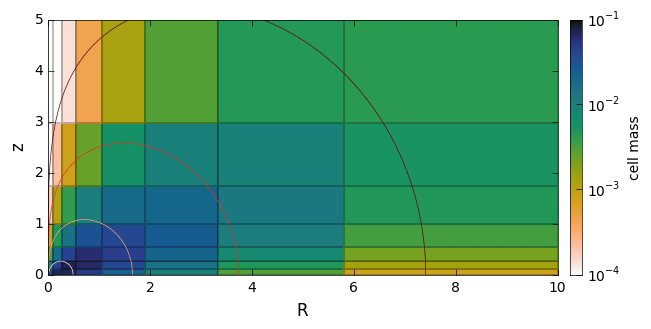

In [5]:
fig = plt.figure(figsize=(6, 3))
axh = plt.axes([0.05, 0.12, 0.85, 0.85], aspect='equal')
axc = plt.axes([0.92, 0.12, 0.02, 0.85])
mesh = axh.pcolormesh(
    gridR, gridz,
    constraints_density.reshape(len(gridz)-1, len(gridR)-1),
    edgecolor=[0,0,0,0.25],
    lw=0.5,
    norm=matplotlib.colors.LogNorm(vmin=1e-4, vmax=1e-1),
    cmap='earth_r')
fig.colorbar(mesh, cax=axc, label='cell mass')
# overplot the contours of 2pi R rho
gridR_plot = numpy.linspace(0, max(gridR), 201)
gridz_plot = numpy.linspace(0, max(gridz), 101)
gridRz_plot = numpy.column_stack((
    numpy.tile  (gridR_plot, len(gridz_plot)),
    numpy.repeat(gridz_plot, len(gridR_plot)),
    numpy.zeros(len(gridR_plot) * len(gridz_plot))))
axh.contour(
    gridR_plot, gridz_plot,
    numpy.maximum(1e-10, 2 * numpy.pi * gridRz_plot[:,0] * numpy.nan_to_num(dens_stars.density(gridRz_plot))).
        reshape(len(gridz_plot), len(gridR_plot)),
    norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1),
    levels=numpy.logspace(-3, 0, 4),
    linewidths=0.5,
    cmap='Reds_r')
axh.set_xlim(min(gridR), max(gridR))
axh.set_ylim(min(gridz), max(gridz))
axh.set_xlabel('R', fontsize=12)
axh.set_ylabel('z', fontsize=12)
None

#### Building the orbit library

Now it is time to construct the orbit library, which is performed by the `orbit` routine discussed in `tutorial_potential_orbits`. As usual, we need to provide the potential, initial conditions, duration of orbit integration (here we use 100 orbital periods for each point, which is pretty common), and the new thing is that we also provide our `Target` that will collect the fraction of time each orbit spends in each cell. The `orbit` routine returns the matrices $\mathsf{D}$ (one for each Target) and the array of `Orbit` interpolator objects (as requested by `dtype=object`).

In [6]:
matrix_density, orbits = agama.orbit(
    potential=pot_total,
    ic=ic,
    time=100*pot_total.Tcirc(ic),
    dtype=object,
    targets=target_density)

2000 orbits complete (329.9 orbits/s)                  


We can visualize a few orbits (most of them look pretty similar in an axisymmetric system, covering a distorted rectangular region in the meridional plane), and verify that rows of matrix $\mathsf{D}$ indeed contain the fraction of time an orbit spends in each cell.<br>
The cyan points are taken from the trajectory at equal times, and of course are denser around the boundaries of the orbit (since it slows down near turnaround points). The color shading of the 2d grid indeed follows the density of sampled points.

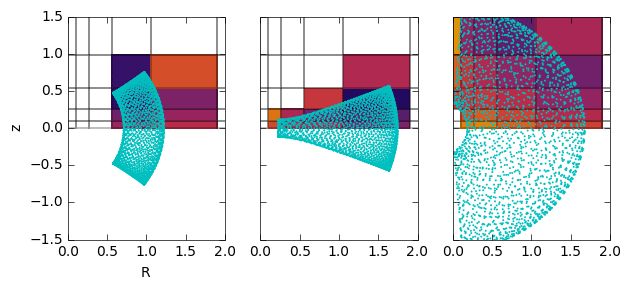

In [7]:
def show_orbit(index, ax):
    orbit = orbits[index]
    t = numpy.linspace(orbit[0], orbit[-1], 2500)  # show the orbit at equally spaced moments in time
    xv = orbit(t)
    orbit_R = (xv[:,0]**2 + xv[:,1]**2)**0.5
    orbit_z = xv[:,2]
    ax.pcolormesh(gridR, gridz, matrix_density[index].reshape(len(gridz)-1, len(gridR)-1),
        edgecolor=(0,0,0,0.25), lw=0.5, norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1), cmap='hell_r')
    ax.scatter(orbit_R, orbit_z, color='c', marker='o', lw=0, s=2)

# pick up a few orbits with mean radii around unity, but different inclinations
orbit_radius = numpy.mean(pot_total.Rperiapo(ic), axis=1)
num_show = 3
select = numpy.argsort(abs(orbit_radius - 1.0))[[0,2,10]]
ax = plt.subplots(1, num_show, figsize=(6.4, 3), sharex=True, sharey=True)[1]
for i in range(num_show):
    show_orbit(select[i], ax[i])
ax[0].set_xlim(0, 2)
ax[0].set_ylim(-1.5, 1.5)
ax[0].set_xlabel('R')
ax[0].set_ylabel('z')
plt.tight_layout()

#### Determining the orbit weights

Now that we have both the matrix $\mathsf{D}$ and the rhs vector of constraints $\boldsymbol{r}$, 
we can solve the linear optimization problem defined above to determine the orbit weights. The array returned by the `orbit` routine has $N_\text{orbits}$ rows and $N_\text{constraints}$ columns, so needs to be transposed to act as the matrix $\mathsf{D}$ in the linear system. The solution is obtained with the `solveOpt` routine; it delegates the task to a third-party quadratic optimization solver `CVXOPT`, which needs to be enabled during the compilation of the `Agama` library (otherwise you will see an error).

In [8]:
weights = agama.solveOpt(matrix=matrix_density.T, rhs=constraints_density)
print('Orbit weights: %s, total mass: %g' % (weights, sum(weights)))

Using a custom optimized KKT solver
numVariables=2000, numConstraints=56, numConsIneq=2000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  4e+01  4e+01  1e+00
 1:  0.0000e+00 -1.8887e-01  1e+02  9e+00  9e+00  4e-03
 2:  0.0000e+00 -6.9346e-03  3e-01  4e-01  4e-01  2e-03
 3:  0.0000e+00 -6.7171e-04  1e-02  8e-02  8e-02  1e-03
 4:  0.0000e+00 -3.1120e-05  7e-04  1e-02  1e-02  3e-04
 5:  0.0000e+00 -3.0270e-05  9e-05  2e-03  2e-03  2e-05
 6:  0.0000e+00 -4.4914e-07  1e-06  4e-05  4e-05  3e-07
 7:  0.0000e+00 -4.4853e-09  1e-08  4e-07  4e-07  3e-09
 8:  0.0000e+00 -4.4852e-11  1e-10  4e-09  4e-09  3e-11
Optimal solution found.
Orbit weights: [ 0.00072004  0.00049639  0.000148   ...,  0.000176    0.00030751
  0.00062497], total mass: 1.01933


The output messages from the solver are somewhat cryptic, but the "Optimal solution found" message is reassuring.

A slight defect is that the weights do not sum up to unity: since the solver was requested only to match the masses inside each cell of the finite grid, it can do whatever it wants to the weights of orbits that do not contribute to any cell at all (i.e. are located at large radii).<br>
We can remedy it by providing another constraint – the total mass of the density profile. As explained above, one can stack multiple matrices $\mathsf{D}^{(k)}$ and rhs vectors $\boldsymbol{r}^{(k)}$, and to avoid copying the data, the `solveOpt` routine can take a list of matrices and rhs vectors. For the total mass constraint, we have just one number (but it still needs to be a vector of length one), and the corresponding matrix $\mathsf{D}$ contains one row filled with ones (since each orbit's contribution to the model mass is its own weight).

In [9]:
weights = agama.solveOpt(
    matrix=[matrix_density.T, numpy.ones((1, num_orbits))],
    rhs=[constraints_density, [total_mass]])
print('Orbit weights: %s, total mass: %g' % (weights, sum(weights)))

Using a custom optimized KKT solver
numVariables=2000, numConstraints=57, numConsIneq=2000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  2e+03  4e+01  4e+01  1e+00
 1:  0.0000e+00 -1.8805e-01  1e+02  9e+00  9e+00  4e-03
 2:  0.0000e+00 -6.2580e-03  3e-01  4e-01  4e-01  2e-03
 3:  0.0000e+00 -6.3030e-04  1e-02  7e-02  7e-02  1e-03
 4:  0.0000e+00 -5.7173e-05  8e-04  2e-02  2e-02  3e-04
 5:  0.0000e+00 -6.6192e-05  2e-04  6e-03  6e-03  6e-05
 6:  0.0000e+00 -1.5065e-06  5e-06  2e-04  2e-04  2e-06
 7:  0.0000e+00 -1.5136e-08  5e-08  2e-06  2e-06  2e-08
 8:  0.0000e+00 -1.5135e-10  5e-10  2e-08  2e-08  2e-10
Optimal solution found.
Orbit weights: [ 0.00073163  0.00049784  0.00015302 ...,  0.00017621  0.00030616
  0.0006262 ], total mass: 1


Now the total mass is also perfectly matched, and the orbit weights have changed very little.

The solution of the optimization problem is not always successful, however.<br>
Let us see what happens if we provide only half of the orbit library (the initial conditions are drawn randomly, so any subset of orbits is still a fair sampling of the model, but it turns out to be insufficient to satisfy all constraints).

In [10]:
num_orbits2 = num_orbits//2
try:
    weights2 = agama.solveOpt(
        matrix=[matrix_density[:num_orbits2].T, numpy.ones((1, num_orbits2))],
        rhs=[constraints_density, [total_mass]])
except Exception as e:
    print(e)

Using a custom optimized KKT solver
numVariables=1000, numConstraints=57, numConsIneq=1000
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  1e+03  3e+01  3e+01  1e+00
 1:  0.0000e+00 -1.8644e-01  7e+01  6e+00  6e+00  4e-03
 2:  0.0000e+00 -7.7726e-03  5e-01  5e-01  5e-01  7e-03
 3:  0.0000e+00 -2.3113e-03  9e-02  2e-01  2e-01  4e-03
 4:  0.0000e+00 -8.5794e-04  6e-02  1e-01  1e-01  3e-03
 5:  0.0000e+00  3.6909e-03  1e-01  1e-01  1e-01  7e-03
 6:  0.0000e+00  1.2956e-01  3e+00  1e-01  1e-01  1e-01
 7:  0.0000e+00  1.2902e+01  3e+02  1e-01  1e-01  1e+01
 8:  0.0000e+00  1.2905e+03  3e+04  1e-01  1e-01  1e+03
 9:  0.0000e+00  1.2905e+05  3e+06  1e-01  1e-01  1e+05
10:  0.0000e+00  1.2905e+07  3e+08  1e-01  1e-01  1e+07
Certificate of primal infeasibility found.
Error in solveOpt(): quadraticOptimizationSolve: problem is infeasible


The specific error message may vary; sometimes it complains about rank-deficient matrices, and the most common failure mode is that the solution does not converge in 100 iterations, while pcost/dcost reach even higher values. In any case, it was not possible to find a solution of our linear system with all weights being non-negative.

So instead we may ask for an *approximate* solution, providing some finite uncertainties $\epsilon_c$ for our constraints (for instance, a fixed relative error of 1 percent). This is effected by adding the `rpenq` parameter ("q" stands for a quadratic penalty as explained at the beginning, and "r" is the penalty for constraints; it is also possible to add linear or quadratic penalties for the vector of unknowns, i.e. weights). The quadratic form $\mathcal Q$ is diagonal in our case, and its elements are inverse squares of uncertainties (times two), just as in the standard linear least-square fitting problem (which is exactly what we are doing here, except that we also add the non-negativity requirement for the solution vector). An extra factor of two appears to compensate the $\frac{1}{2}$ in the definition of $\mathcal Q = \frac{1}{2} \boldsymbol{w}^T\, \mathsf{Q}\, \boldsymbol{w}$. An infinite penalty means that the corresponding constraint has to be satisfied exactly (we use this for the total mass, since it is almost always pretty easy to satisfy).

After obtaining the new vector of weights that solve the linear system approximately, we may examine which constraints were not satisfied (i.e. where the product of matrix $\mathsf{D}$ times the solution vector $\boldsymbol w$ does not match the rhs $\boldsymbol{r}$).

In [11]:
constraints_density_uncertainty = 0.01 * constraints_density
weights2 = agama.solveOpt(
    matrix=[matrix_density[:num_orbits2].T, numpy.ones((1, num_orbits2))],
    rhs=[constraints_density, [total_mass]],
    rpenq=[2*constraints_density_uncertainty**-2, [numpy.inf]])

def check_solution():
    actual_density = matrix_density[:num_orbits2].T.dot(weights2)
    bad_cells = numpy.where(abs(actual_density - constraints_density) > constraints_density_uncertainty)[0]
    for c in bad_cells:
        print('cell %s, required mass=%g, actual mass=%g, difference=%.3g%%' %
            (target_density[c], constraints_density[c], actual_density[c],
             (actual_density[c]/constraints_density[c]-1)*100))

check_solution()

Using a custom optimized KKT solver
numVariables=1056, numConstraints=57, numConsIneq=1000
     pcost       dcost       gap    pres   dres
 0:  6.3622e-09 -1.0145e+00  1e+03  3e+01  3e+01
 1:  5.5448e-08 -1.0069e+00  3e+01  8e-01  8e-01
 2:  3.6527e-05 -8.6288e-01  6e+00  2e-01  2e-01
 3:  4.7024e-04 -6.3110e-01  4e+00  9e-02  9e-02
 4:  1.6493e-03 -3.7952e-01  4e+00  8e-02  8e-02
 5:  1.5668e-02  7.4749e-01  3e+00  6e-02  6e-02
 6:  2.7573e-01  5.8841e+00  4e+00  6e-02  6e-02
 7:  4.1281e+00  2.2413e+01  8e+00  5e-02  5e-02
 8:  6.0659e+00  2.6361e+01  9e+00  4e-02  5e-02
 9:  1.0590e+01  3.2700e+01  1e+01  4e-02  4e-02
10:  1.4677e+01  3.6833e+01  1e+01  3e-02  3e-02
11:  1.7119e+01  3.9677e+01  1e+01  3e-02  3e-02
12:  1.7025e+01  4.0112e+01  1e+01  3e-02  3e-02
13:  1.7647e+01  4.1175e+01  1e+01  3e-02  3e-02
14:  1.9646e+01  4.4104e+01  1e+01  3e-02  3e-02
15:  2.3910e+01  4.8944e+01  1e+01  2e-02  2e-02
16:  2.9121e+01  5.3388e+01  1e+01  2e-02  2e-02
17:  3.1967e+01  5.5954e+01 

So it was struggling to satisfy a few cell masses in the outskirts of the model, and the discrepancy does not exceed a few percent – we might declare it insignificant, but it is always worth checking.

One can also use a *linear* (not *quadratic*) penalty for density constraints (passing it as a `rpenl` argument); this adds a term<br>
$\displaystyle \sum\limits_{c=1}^{N_\text{constraints}} \left| \frac{\displaystyle \sum\nolimits_{i=1}^{N_\text{orbits}} D_{c,i}\, w_i - r_c}{\displaystyle \epsilon_c} \right|$<br>
to the objective function $\mathcal Q$. The advantage of this "$L_1$ penalty" is that it minimizes the number of rows in the linear system that cannot be satisfied exactly, rather than "spreading the problem" over a larger number of rows but with smaller deviations in each.

In [12]:
weights2 = agama.solveOpt(
    matrix=[matrix_density[:num_orbits2].T, numpy.ones((1, num_orbits2))],
    rhs=[constraints_density, [total_mass]],
    rpenl=[constraints_density_uncertainty**-1, [numpy.inf]])
check_solution()

Using a custom optimized KKT solver
numVariables=1112, numConstraints=57, numConsIneq=1112
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -0.0000e+00  5e+07  3e+01  1e-06  1e+00
 1: -1.0376e+00 -1.0062e+00  1e+06  6e-01  3e-08  5e-02
 2: -1.1994e+01 -1.1731e+01  1e+06  6e-01  2e-08  3e-01
 3: -2.4947e+01 -2.4466e+01  8e+05  5e-01  2e-08  5e-01
 4: -1.0092e+02 -9.9242e+01  7e+05  5e-01  2e-08  2e+00
 5: -8.1003e+01 -8.0949e+01  2e+04  1e-02  5e-10  5e-02
 6: -1.9354e+02 -1.9330e+02  2e+04  1e-02  5e-10  2e-01
 7: -4.9859e+02 -4.9786e+02  2e+04  1e-02  5e-10  7e-01
 8: -1.2486e+03 -1.2467e+03  2e+04  1e-02  4e-10  2e+00
 9: -1.6867e+03 -1.6843e+03  6e+03  4e-03  2e-10  2e+00
10: -6.1563e+02 -6.1471e+02  2e+03  1e-03  5e-11  9e-01
11: -8.9703e+02 -8.9588e+02  2e+03  1e-03  5e-11  1e+00
12: -3.1139e+02 -3.1097e+02  6e+02  4e-04  2e-11  4e-01
13: -9.0198e+01 -9.0061e+01  2e+02  1e-04  4e-12  1e-01
14: -7.4319e+01 -7.4203e+01  1e+02  8e-05  3e-12  1e-01
15: -3.3824e+01

#### Creating N-body snapshots

One of the applications of the method is the construction of equilibrium initial conditions for $N$-body simulations, so we would like to create an $N$-body snapshot from our orbit-superposition model.

During the orbit integration, we already stored the trajectories represented by `Orbit` classes (a thin wrapper on top of spline interpolators). Now it is fairly easy to sample the required number of points from each trajectory, in proportion to its weight in the model. This task is performed by the routine `sampleOrbitLibrary`, which returns a success flag (True/False) and the result.
Since the orbit interpolators can be sampled with as many points as needed, the procedure always succeeds; had we chosen to store trajectories as arrays of fixed (predetermined) size, it may have failed if the number of samples drawn from some high-weight orbits exceeds the size of recorded trajectories, necessitating to re-integrate some orbits. But with interpolators, the procedure is really straightforward.

This method places many particles on formally identical orbits, but in practice, they will quickly spread out due to inevitable fluctuations of the potential in an $N$-body system.

When running a simulation, we would need to add the central black hole as another particle (initially at rest at origin).

In [13]:
Nbody = 100000
success, (snap_posvel, snap_mass) = agama.sampleOrbitLibrary(Nbody, orbits, weights)
print(success)

True


#### Examining the model

Alright, what can we do with this snapshot?<br>
The first thing to check is whether it is in an equilibrium. The ultimate check would be to run an actual $N$-body simulation, which is beyond the scope of this tutorial), but a weaker check is to examine the virial ratio (the ratio of kinetic and potential energy), which should be close to unity. The kinetic energy $\displaystyle E_\text{kin} = \frac{1}{2} \sum\nolimits_{j=1}^{N_\text{body}} m_j\,|\boldsymbol{v}_j|^2$ can be computed directly from particles, and the potential energy $\displaystyle E_\text{pot} = \frac{1}{2} \sum\nolimits_{j=1}^{N_\text{body}} m_j\,\Phi(\boldsymbol{x}_j)$ needs the potential of the $N$-body system – well, we can approximate it by constructing a `Multipole` potential from the particle snapshot.

In [14]:
pot_stars_nbody = agama.Potential(type='multipole', particles=(snap_posvel, snap_mass), symmetry='a')
E_kin = 0.5 * numpy.sum(snap_mass[:,None] * snap_posvel[:,3:6]**2)
E_pot = 0.5 * numpy.sum(snap_mass * pot_stars_nbody.potential(snap_posvel[:,0:3]))
print('Epot=%g, Ekin=%g, virial ratio=%g' % (E_pot, E_kin, -2*E_kin/E_pot))

Epot=-0.464412, Ekin=0.343409, virial ratio=1.4789


Bang, something is wrong! The virial ratio should be around unity, but it is not.

We forgot that our model had a second component – a central black hole. It contributes nothing to the kinetic energy, but quite a lot to the potential energy; we need to use the _total_ potential when summing over all particles' $E_\text{pot}$, and also add $E_\text{pot}$ of the black hole itself – it is evaluated in the stellar potential only (not including its own potential, which would make the energy infinite).

In [15]:
E_pot += 0.5 * (numpy.sum(snap_mass * pot_bh.potential(snap_posvel[:,0:3])) +
    pot_bh.totalMass() * pot_stars_nbody.potential(0,0,0))
print('Epot=%g, Ekin=%g, virial ratio=%g' % (E_pot, E_kin, -2*E_kin/E_pot))

Epot=-inf, Ekin=0.343409, virial ratio=0


Okay, now this looks sensible, at least the ratio is around unity – probably the model is indeed close to equilibrium (unless it somehow managed to have wrong values of both kinetic and potential energy).<br>
For the peace of mind, let us compute the expected value of the potential energy from the definition:<br>
$\displaystyle E_\text{pot} = \frac{1}{2} \iiint \rho(\boldsymbol{x})\, \Phi(\boldsymbol{x})\, d^3 x = \frac{1}{2} \int_0^\infty dr\, r^2  \int_0^\pi d\theta\, \sin\theta \int_0^{2\pi} d\phi\; \rho(r,\theta,\phi)\,\Phi(r,\theta,\phi)$.<br>
In the case of axisymmetric systems, the integral over the azimuthal angle $\phi$ is trivial, and the remaining two spatial dimensions ($\theta$ and $r$) need to be integrated over numerically. We use the `integrateNdim` function from `Agama`, which integrates over a finite region (2d rectangle in our case), so we change variables from $\{r,\theta\}$ to $\{\xi \equiv \tanh r \in [0..1), \eta \equiv \cos\theta\}$. The integral is written as<br>
$\displaystyle E_\text{pot} = \frac{1}{2} \int_0^1 d\xi\, \frac{2\pi\,\text{arctanh}^2\xi}{1-\xi^2} \int_{-1}^1 d\eta\; \rho\,\Phi$.<br>
As explained above, we need to use the total potential (including the central BH) as $\Phi$, but only the density of stars as $\rho$, and separately add the potential energy of the central BH in the stellar potential.

In [16]:
def compute_potential_energy(density, potential):
    def integrand(var):
        xi, costheta = var.T
        sintheta = (1-costheta**2)**0.5
        r = numpy.arctanh(xi)
        jac = 2*numpy.pi * r**2 / (1-xi**2)
        x = numpy.column_stack((r * sintheta, r * 0, r * costheta))
        return numpy.nan_to_num(density.density(x) * potential.potential(x) * jac)
    with numpy.errstate(all='ignore'):
        # ignore warnings about invalid values when evaluating integrand at infinity and suchlike
        return 0.5 * agama.integrateNdim(integrand, lower=[0,-1], upper=[1,1])[0]

E_pot_true = (compute_potential_energy(dens_stars, pot_total) +
    0.5 * pot_bh.totalMass() * pot_stars.potential(0,0,0))
print('True Epot=%g; fractional difference from Nbody: %.2g' % (E_pot_true, E_pot/E_pot_true-1))

True Epot=-0.695364; fractional difference from Nbody: inf


So indeed, the $N$-body system has very nearly the same potential energy as the smooth model, and likely close to equilibrium – to be entirely sure, one would need to run the full $N$-body simulation.

The next thing we can check is the shape of the $N$-body snapshot. The standard method for computing the shape from the moment of inertia tensor can be applied to the snapshot itself (and there is an implementation of this method included in the repository as `measureshape.py`), but for simplicity, we will use the above constructed `Multipole` approximation of the snapshot, which (as any density model in `Agama`) also provides a method for computing the principal axes. The ratio of smallest to largest axes should be similar to the flattening $q$ of our input density profile.

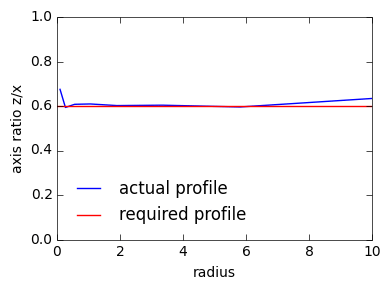

In [17]:
axes = pot_stars_nbody.principalAxes(gridR)[0]
plt.figure(figsize=(4,3))
plt.plot(gridR, axes[:,2] / axes[:,0], c='b', label='actual profile')
plt.axhline(q, color='r', label='required profile')
plt.xlim(min(gridR), max(gridR))
plt.ylim(0, 1)
plt.xlabel('radius')
plt.ylabel('axis ratio z/x')
plt.legend(loc='lower left', frameon=False)
plt.tight_layout()

Also looks good. The slight deviation in the inner part may be due to insufficient resolution of our spatial grid – the innermost radius was set to 0.1, and since there is only one square cell near the origin, the shape of the density profile at small radii is not constrained at all. Later we will see how to improve it, but for now let's turn to another sanity check: the velocity distributions of particles. We can compute three velocity components in spherical coordinates, and plot them against spherical radius, to see if the model looks sensible.

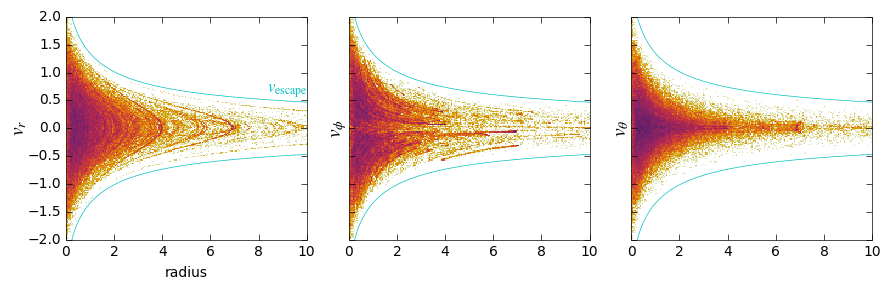

In [18]:
snap_R  = numpy.sum(snap_posvel[:,0:2]**2, axis=1)**0.5
snap_r  = numpy.sum(snap_posvel[:,0:3]**2, axis=1)**0.5
snap_vr = numpy.sum(snap_posvel[:,0:3] * snap_posvel[:,3:6], axis=1) / snap_r
snap_vphi = (snap_posvel[:,0] * snap_posvel[:,4] - snap_posvel[:,1] * snap_posvel[:,3]) / snap_R
snap_vtheta = (numpy.sum(snap_posvel[:,0:2] * snap_posvel[:,3:5], axis=1) / snap_R * snap_posvel[:,2] 
    - snap_R * snap_posvel[:,5]) / snap_r

ax = plt.subplots(1, 3, figsize=(9, 3), sharex=True, sharey=True)[1]
bins_r = numpy.linspace(0, 10, 200)
bins_v = numpy.linspace(-2, 2, 200)
hist_params = dict(
    bins=(bins_r, bins_v),
    weights=snap_mass / (bins_r[1]-bins_r[0]) / (bins_v[1]-bins_v[0]),
    norm=matplotlib.colors.LogNorm(vmin=5e-3, vmax=5),
    cmap='hell_r')
ax[0].hist2d(snap_r, snap_vr, **hist_params)
ax[1].hist2d(snap_r, snap_vphi, **hist_params)
ax[2].hist2d(snap_r, snap_vtheta, **hist_params)
ax[0].set_xlabel('radius')
ax[0].set_ylabel(r'$v_r$', labelpad=0, fontsize=14)
ax[1].set_ylabel(r'$v_\phi$', labelpad=0, fontsize=14)
ax[2].set_ylabel(r'$v_\theta$', labelpad=0, fontsize=14)
ax[0].set_xlim(0, 10)
ax[0].set_ylim(-2, 2)
# overplot the escape velocity as a function of radius
v_esc = (-2 * pot_total.potential(numpy.column_stack((gridR_plot, gridR_plot*0, gridR_plot*0))))**0.5
for a in ax:
    a.plot(gridR_plot,  v_esc, color='c', lw=0.5)
    a.plot(gridR_plot, -v_esc, color='c', lw=0.5)
ax[0].text(10, v_esc[-1]*1.1, r'$v_{\rm escape}$ ', ha='right', va='bottom', color='c', fontsize=12)
plt.tight_layout()

Hmmm, not quite perfect – the inner regions seem to be well mixed, but in the outskirts, there are clear patterns apparently tracing out individual orbits. This may happen if the size of the orbit library is not large enough, and some orbits get particularly high weights. We may see this from the weight distribution of orbits plotted against radius – indeed, there are a few that stand out at large radii.

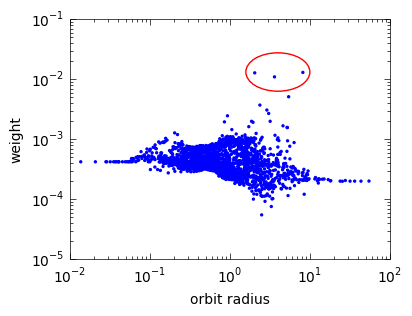

In [19]:
plt.figure(figsize=(4,3))
ax = plt.axes([0.18, 0.18, 0.8, 0.8])
ax.scatter(orbit_radius, weights, s=2, color='b', clip_on=False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(1e-2, 1e2)
ax.set_ylim(1e-5, 1e-1)
ax.set_xlabel('orbit radius')
ax.set_ylabel('weight')
ax.add_artist(matplotlib.patches.Ellipse((0.65, 0.78), 0.2, 0.16, fill=False, color='r', transform=ax.transAxes))
None

If we repeat this exercise with a larger number of orbits (say, 10000 or more), these patterns virtually disappear.

#### Velocity anisotropy profiles

Instead of looking at 2d distributions of radius vs. velocity, we can condense them into the 1d velocity anisotropy profile: $\displaystyle \beta(r) \equiv 1 - \frac{1}{2} \frac{\sigma_\text{tan}^2}{\sigma_\text{rad}^2}$, where the radial and tangential velocity dispersions are $\sigma_\text{rad}^2 = \overline{v_r^2}$ and $\sigma_\text{tan}^2 = \overline {v_\theta^2} + \overline{v_\phi^2}$.

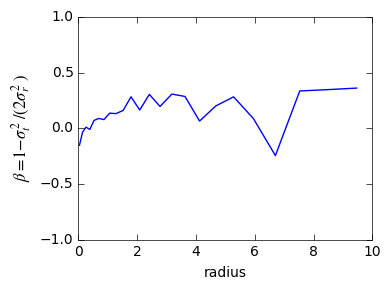

In [20]:
def plot_beta_profile(snap_posvel, snap_mass):
    snap_r   =  numpy.sum(snap_posvel[:,0:3]**2, axis=1)**0.5
    snap_vr2 = (numpy.sum(snap_posvel[:,0:3] * snap_posvel[:,3:6], axis=1) / snap_r)**2
    snap_vt2 = (numpy.sum(snap_posvel[:,3:6]**2, axis=1) - snap_vr2)
    bins_r   = agama.nonuniformGrid(25, 0.1, 10)
    hist_vr2 = numpy.histogram(snap_r, bins=bins_r, weights=snap_mass * snap_vr2)[0]
    hist_vt2 = numpy.histogram(snap_r, bins=bins_r, weights=snap_mass * snap_vt2)[0]
    plt.figure(figsize=(4,3))
    plt.plot((bins_r[1:]+bins_r[:-1])/2, 1 - 0.5 * hist_vt2 / hist_vr2, label='actual profile', color='b')
    plt.xlim(min(bins_r), max(bins_r))
    plt.ylim(-1, 1)
    plt.xlabel('radius')
    plt.ylabel(r'$\beta = 1 - \sigma_t^2 / (2\sigma_r^2)$', fontsize=12)
    plt.tight_layout()

plot_beta_profile(snap_posvel, snap_mass)

This looks somewhat jagged (likely reflecting the undesirable structures in the velocity distributions at large radii shown earlier), but in general quite close to isotropy ($\beta=0$). We have not explicitly set any constraints on the velocity anisotropy, so this result is largely determined by the initial conditions of the orbit library, which were indeed sampled with isotropic velocities (more on that later).

We can actually set some constraints on the $\beta$ profile, but for this, we should have recorded some velocity information from individual orbits, not just their density contributions. This task is performed by another type of `Target` object, which records the integrals of radial and tangential velocity dispersions over spherical shells:
$\displaystyle E_{\text{rad},s} \equiv \iiint_{\boldsymbol x\in S_s} \rho(\boldsymbol{x})\, v_r^2 \; d^3x$ and similarly for $E_\text{tan}$,
where $S_s$ is the spatial region occupied by $s$-th shell. This is similar to the spatial grid for density discretization, but simpler in the sense of using just a 1d grid in spherical radius; OTOH we record two components of velocity dispersions, hence the size of this dataset is twice the size of the grid.

We create an instance of this kinematic target, and can apply it to the already computed orbit library to obtain the kinematic matrix $\mathsf{C}$.  A better way would be to pass it along with the density target during the construction of the orbit library from the very beginning, as shown in the last statement.

In [21]:
target_kinem = agama.Target(type='KinemShell', gridr=gridR, degree=1)   # "degree" will be explained later

try:
    matrix_kinem = target_kinem(orbits)
except TypeError:
    # the above feature is not available in older versions of the library; as a fallback, we need to construct
    # the orbit library again while providing both target objects to collect data during orbit integrations
    matrix_density, matrix_kinem, orbits = agama.orbit(
        potential=pot_total,
        ic=ic,
        time=100*pot_total.Tcirc(ic),
        dtype=object,
        targets=[target_density, target_kinem])

Now we can use the same already constructed orbit library to create variants of models with different anisotropy profiles $\beta(r)$.

The procedure for adding the anisotropy constraint to the linear system is slighly more complicated, since we need to express it as a linear function of recorded velocity dispersions that will be multiplied by orbit weights to produce some required value in the r.h.s.
By rearranging the definition of the anisotropy parameter, we obtain $2 \big[1-\beta(r)\big] \sigma_\text{rad}^2 - \sigma_\text{tan}^2 = 0$. The l.h.s. is a function sampled for each orbit at the values of radii provided to the Target object (elements of one row in matrix $\mathsf{C}$), and we can put any desired profile of $\beta(r)$ into this expression to obtain the *transformed* matrix $\mathsf{D}$ of orbit contributions to each kinematic constraint; the r.h.s. is always zero.<br>
The helper function below takes the profile $\beta(r)$ and creates this transformed matrix, then solves the optimization problem to obtain orbit weights, and creates an $N$-body representation of this model, from which we may plot the resulting anisotropy profile just as in the previous fragment. 
This time there will be three matrices and three sets of constraints: density discretized on the grid, kinematics (on a different grid), and total mass. Of these, the first and the last sets are specified as equality constraints, but because not all possible $\beta$ profiles can be reproduced exactly, we assign some finite penalty for violating these kinematic constraints (just as we did earlier with density constraints in a small orbit library). 

In [22]:
def solve_with_beta_profile(beta_profile):
    Ngrid = len(target_kinem) // 2
    # Ngrid values of rho sigma_r^2, then the same number of values of rho sigma_t^2;
    # we combine them into a single array of Ngrid values that enforce isotropy (sigma_t^2 - 2 sigma_r^2 = 0)
    matrix_kinem_transformed = 2 * (1 - beta_profile(gridR)) * matrix_kinem[:,:Ngrid] - matrix_kinem[:,Ngrid:]
    constraints_kinem  = numpy.zeros(Ngrid)
    weights = agama.solveOpt(matrix=[matrix_density.T, matrix_kinem_transformed.T, numpy.ones((1, num_orbits))], 
        rhs=[constraints_density, constraints_kinem, [1.0]],
        rpenq=[constraints_density+numpy.inf, numpy.ones(Ngrid), [numpy.inf]])
    return agama.sampleOrbitLibrary(Nbody, orbits, weights)[1]

Let us illustrate this for two different choices of anisotropy profile: the first starts from $\beta=0$ zero and gradually becomes more radially anisotropic at large radii (though not as quickly as the commonly used Osipkov–Merritt profile), and the second is a constant mild tangential anisotropy $\beta=-0.5$.

Using a custom optimized KKT solver
numVariables=2009, numConstraints=66, numConsIneq=2000
     pcost       dcost       gap    pres   dres
 0:  3.4154e-06 -1.0076e+00  2e+03  4e+01  5e+01
 1:  1.3015e-05 -1.0060e+00  2e+01  5e-01  5e-01
 2:  2.4958e-04 -8.9637e-01  2e+00  3e-02  3e-02
 3:  3.6374e-04 -3.7424e-01  4e-01  2e-03  2e-03
 4:  2.8746e-04 -2.3954e-02  2e-02  9e-05  9e-05
 5:  3.5549e-05 -2.7432e-03  3e-03  3e-07  3e-07
 6:  6.3992e-06 -4.5484e-04  5e-04  8e-09  8e-09
 7:  1.7690e-06 -2.6983e-04  3e-04  2e-09  2e-09
 8:  3.8155e-07 -2.4222e-05  2e-05  2e-10  2e-10
 9:  5.8623e-08 -3.2225e-06  3e-06  8e-16  7e-19
10:  6.8038e-09 -4.6466e-07  5e-07  2e-15  1e-19
11:  1.8496e-09 -1.0284e-07  1e-07  6e-15  2e-20
12:  3.8670e-10 -5.5402e-08  6e-08  5e-15  5e-21
Optimal solution found.


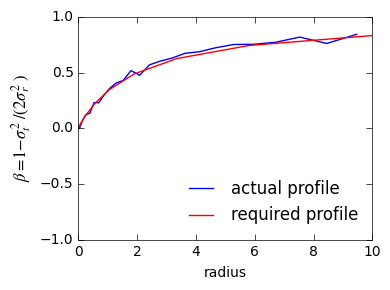

In [23]:
beta_profile_radially_anisotropic = lambda r: r / (r + 2.0)
snap_posvel_rad, snap_mass_rad = solve_with_beta_profile(beta_profile_radially_anisotropic)
plot_beta_profile(snap_posvel_rad, snap_mass_rad)
plt.plot( gridR, beta_profile_radially_anisotropic(gridR), color='r', label='required profile')
plt.legend(loc='lower right', frameon=False)
None

Using a custom optimized KKT solver
numVariables=2009, numConstraints=66, numConsIneq=2000
     pcost       dcost       gap    pres   dres
 0:  2.2305e-06 -1.0075e+00  2e+03  4e+01  5e+01
 1:  1.3369e-05 -1.0057e+00  3e+01  5e-01  5e-01
 2:  1.6375e-03 -8.9620e-01  2e+00  3e-02  3e-02
 3:  2.9200e-03 -3.7678e-01  4e-01  3e-03  3e-03
 4:  1.7008e-03 -4.4010e-02  5e-02  2e-04  2e-04
 5:  1.3530e-04 -1.1622e-02  1e-02  1e-15  7e-16
 6:  1.7216e-05 -1.5757e-03  2e-03  7e-16  2e-16
 7:  1.0315e-06 -2.0693e-04  2e-04  3e-15  3e-17
 8:  7.4323e-08 -3.7449e-05  4e-05  2e-15  5e-18
 9:  4.4087e-08 -8.1845e-06  8e-06  2e-15  1e-18
10:  8.1115e-09 -3.7952e-06  4e-06  1e-15  2e-19
11:  1.4874e-09 -6.2111e-07  6e-07  1e-15  8e-20
12:  4.9023e-12 -3.7178e-08  4e-08  1e-15  1e-20
Optimal solution found.


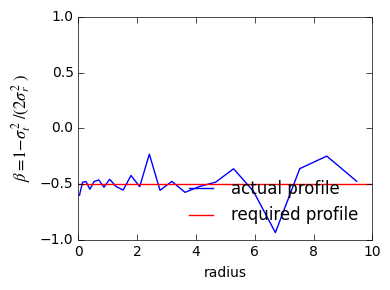

In [24]:
beta_profile_tangentially_anisotropic = lambda r: -0.5
snap_posvel_tan, snap_mass_tan = solve_with_beta_profile(beta_profile_tangentially_anisotropic)
plot_beta_profile(snap_posvel_tan, snap_mass_tan)
plt.axhline(beta_profile_tangentially_anisotropic(0), color='r', label='required profile')
plt.legend(loc='lower right', frameon=False)
None

#### Different density discretization schemes

So far we have used `Target(type="DensityCylindricalTopHat")`, what other types are available and when to use them?


Another variant is the `DensityClassicTopHat` discretization scheme, which goes back to the original Schwarzschild's paper. In this scheme, there is a grid in radius, and the surface of each spherical shell is divided into cells as follows.
One octant of space ($x,y,z\ge 0$) is partitioned into three spherical rectangles ("panes"), then each pane is divided into $N_\text{strips}^2$ smaller squares. One octant is sufficient for models with at most triaxial symmetry; during orbit integration, point coordinates are taken with absolute values and placed into the corresponding cell.

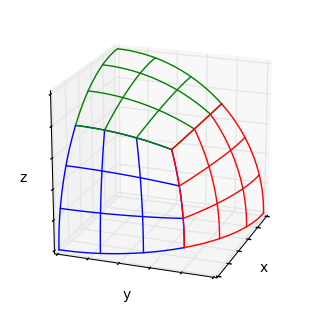

In [25]:
def show_classic_grid(num_strips):
    import mpl_toolkits.mplot3d
    plt.figure(figsize=(3,3))
    ax = plt.axes([0,0,1,1], projection='3d')
    ax.view_init(elev=20, azim=20)
    num_points = 20
    for i in range(num_strips+1):
        alpha = i * numpy.pi/4/num_strips
        betas = numpy.linspace(0, numpy.pi/4, num_points)
        y_over_x = numpy.tan(alpha)
        z_over_x = numpy.tan(betas)
        x,y,z = numpy.array([betas*0+1, betas*0+y_over_x, z_over_x]) / (1 + y_over_x**2 + z_over_x**2)**0.5
        ax.plot(x, y, z, color='b')
        ax.plot(x, z, y, color='b')
        ax.plot(y, z, x, color='g')
        ax.plot(z, y, x, color='g')
        ax.plot(z, x, y, color='r')
        ax.plot(y, x, z, color='r')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_zticklabels([])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
show_classic_grid(3)

The choice of the radial grid is up to the user, and may be guided by the need to resolve some features in the inner part of the galaxy (e.g. the BH sphere of influence), as well as cover nearly all of the mass (say, 99%). An exponentially-spaced radial grid is often a good choice.<br>
One can further compress or stretch the grid along $y$ and $z$ axes by some factors, effectively replacing the spherical radius by elliptical radius; this may be useful for better aligning the grid with the density profile, helping to make cell masses more uniform.
 
Finally, instead of integrating the density $\rho(r,\theta,\phi)$ over the volume of the cells, one can first transform it into a spherical-harmonic expansion, then integrate each term $\rho_{\ell,m}(r)$ over the radial grid shell. This approach is implemented by the `DensitySphHarm` target type.

The optimal choice of the discretization scheme depends on the density profile. Both classic and spherical-harmonic schemes are more suited for models of spheroidal components (bulges, haloes). The radial grid in the classic scheme can be arbitrarily stretched along principal axes, making it more adapted even to highly flattened profiles, but since the way of partitioning the octant into three panes is geared towards triaxial models, it may be less optimal for axisymmetric ones.<br>
OTOH in the spherical-harmonic scheme, one can explicitly specify the orders of expansion $\ell_\text{max}$, $m_\text{max}$, in particular, setting the latter to zero for axisymmetric systems, thereby eliminating redundancy in cell placement. But the downside is that one cannot use elliptical radius in this scheme. <br>
The cylindrical grid may be better suited for disky profiles, and it is also generalized to non-axisymmetric systems by adding the Fourier expansion in $\phi$ up to some $m_\text{max}$, so can represent barred models. However, a separable grid in $R$ and $z$ may not be optimal for some models, where the cells at the corners of the grid may have very stretched shapes and low masses (as in our example above, in which a small orbit library could not satisfy the density constraints at large $R$ and low $z$).

Both cylindrical and classic schemes come in two variants, with "TopHat" and "Linear" suffixes, of which we have used the first one. The "TopHat" in its name refers to the way the cell masses are computed: integrating the density multiplied by a trivial weighting function that is either 1 if the point is inside the cell, or 0 otherwise. However, one can use more complicated weighting functions, in particular, B-splines of some degree $B$ (with a top-hat function being a B-spline of degree zero).

#### Digression: B-splines

This mathematical construct is used in many places throughout the entire `Agama` library and the orbit-superposition module in particular, so it is worth describing its main properties.

B-splines form a basis set defined by the degree $B$ and the grid nodes $x_k$, $k=1..N_\text{grid}$: the interpolated function is represented as a weighted sum of basis functions $\sum_{i=1}^{N_\text{basis}} a_i\, F_i(x)$, where $\boldsymbol a$ is the vector of amplitudes. Each basis function $F_i(x)$ is a polynomial of degree $B$ on at most $B+1$ consecutive grid segments, and zero elsewhere; at grid nodes, the function has $B$ continuous derivatives. For instance, $B=0$ corresponds to top-hat functions that equal 1 inside one segment and 0 elsewhere, so are discontinuous at grid nodes. $B=1$ basis functions linearly rise from 0 to 1 across the grid segment $x_{k-1}$..$x_k$, then linearly fall back to zero on the next segment $x_k..x_{k+1}$. In total, there are $N_\text{basis} = N_\text{grid} + B - 1$ basis functions, illustrated below for a three-segment grid and $B=1,2$:

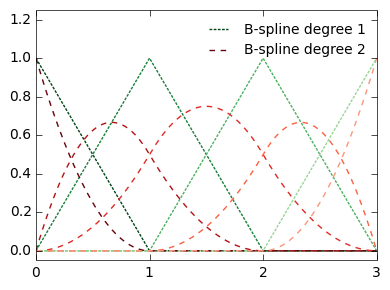

In [26]:
grid_size = 4  # number of nodes; the number of segments is one fewer
grid_nodes = numpy.linspace(0, 3, grid_size)
x = numpy.linspace(grid_nodes[0], grid_nodes[-1], 100*(grid_size-1)+1)  # grid for plotting

# The agama.Spline class can represent different types of splines, and in particular,
# a B-spline interpolator is specified by the grid nodes and a vector of amplitudes.
# To visualize individual basis functions, we provide a vector of amplitudes
# with all zeros except one element.

def show_bspline_functions(degree, cmap, **plot_kwargs):
    basis_size = grid_size + degree - 1
    for i in range(basis_size):
        ampl_i = numpy.eye(basis_size)[i]  # select i-th row of the identity matrix to show one basis function
        basis_fnc = agama.Spline(grid_nodes, ampl=ampl_i)
        plt.plot(x, basis_fnc(x),
            label='B-spline degree %i' % degree if i==0 else None,
            color=plt.get_cmap(cmap)(i*0.8/basis_size), **plot_kwargs)

ax = plt.subplots(1, 1, figsize=(4,3))[1]
show_bspline_functions(1, 'Greens_r', dashes=[2,1])
show_bspline_functions(2, 'Reds_r', dashes=[4,4])
plt.legend(loc='upper right', frameon=False, fontsize=10)
ax.set_xticks(grid_nodes)
ax.set_xlim(min(grid_nodes), max(grid_nodes))
ax.set_ylim(-0.05, 1.25)
plt.tight_layout()

Any given function $g(x)$ can be approximated by a B-spline $\tilde g(x) \equiv \sum_i a_i\,F_i(x)$ using the following approach, which is similar to the Fourier expansion, but generalized to the case of a non-orthonormal basis set.<br>
Define the projection $P_i[g]$ of a function $g(x)$ onto the $i$-th basis function as the inner product of $g(x)$ and the basis function $F_i(x)$, namely $\int g(x)\,F_i(x)\;dx$. We require that the projections of the interpolated function $\tilde g(x)$ coincide with the projections of the original function $g(x)$ for all basis elements. Since $\tilde g$ is a linear combination of basis functions, one can write the vector of its projections as $\boldsymbol P[\tilde g] = \mathsf{M}\,\boldsymbol a$, where the matrix $\mathsf{M}$ contains the pairwise inner products of all basis functions: $M_{i,j} = \int F_i(x)\,F_j(x)\;dx$.<br>
So to find the amplitudes $\boldsymbol a$, we construct the basis matrix $\mathsf{M}$ and compute the vector of projections of the input function $\boldsymbol P[g]$, then solve $\mathsf{M}\,\boldsymbol a = \boldsymbol P[g]$.


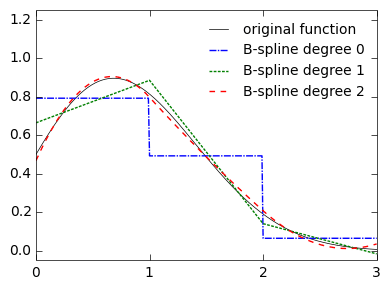

In [27]:
def fnc(x):
    return numpy.exp(-0.5*x*x) * (0.5+numpy.sin(x))

import scipy.integrate

def integrate(integrand):
    # since B-spline basis functions or some of their derivatives are discontinuous at grid nodes,
    # we integrate separately on each grid segment and sum up results, otherwise it would be inaccurate
    return sum([
        scipy.integrate.quad(integrand, grid_nodes[i], grid_nodes[i+1])[0]
        for i in range(len(grid_nodes)-1)
    ])

def compute_projection_fnc(basis_fncs):
    return [
        integrate(lambda x: fnc(x) * basis_fnc(x))
        for basis_fnc in basis_fncs ]

def show_bspline_approximation(degree, compute_projection, ax, **plot_kwargs):
    basis_size = grid_size + degree - 1
    basis_fncs = [
        agama.Spline(grid_nodes, ampl=numpy.eye(basis_size)[i])
        for i in range(basis_size) ]
    basis_matrix = [[
        integrate(lambda x: basis_fncs[i](x) * basis_fncs[k](x))
        for i in range(basis_size) ] 
        for k in range(basis_size) ]
    projection = compute_projection(basis_fncs)
    ampl = numpy.linalg.solve(basis_matrix, projection)
    ax.plot(x, agama.Spline(grid_nodes, ampl=ampl)(x),
        label='B-spline degree %i' % degree, **plot_kwargs)

def show_three_bspline_approximations(ax, compute_projection):
    show_bspline_approximation(0, compute_projection, ax, color='b', dashes=[5,1,1,1])
    show_bspline_approximation(1, compute_projection, ax, color='g', dashes=[2,1])
    show_bspline_approximation(2, compute_projection, ax, color='r', dashes=[4,4])
    ax.set_xticks(grid_nodes)
    ax.set_xlim(min(grid_nodes), max(grid_nodes))
    
ax = plt.subplots(1, 1, figsize=(4,3))[1]
ax.plot(x, fnc(x), c='k', lw=0.5, label='original function')
show_three_bspline_approximations(ax, compute_projection_fnc)
ax.legend(loc='upper right', frameon=False, fontsize=10)
ax.set_ylim(-0.05, 1.25)
plt.tight_layout()

Clearly, higher-degree B-splines are far better at approximating smooth functions (even after adjusting the number of nodes to compensate for extra degrees of freedom for higher-degree splines).

However, this higher accuracy is only achieved for smooth functions that vary on scales larger than the spacing of the B-spline grid. Higher-degree splines still provide some information about features on sub-grid scales, as demonstrated by the following example. Here we push the method to the limit by trying to approximate a delta-function; of course, all spline interpolators will have widths comparable to the grid spacing, but while the location of the delta-function within one grid segment cannot be distinguished in a histogram, it still affects the shape of B-splines of degree 1 and above. Note also that the interpolated functions display some oscillations and attain negative values (Gibbs phenomenon), which is an unavoidable when trying to approximate discontinuous functions with continuous splines.

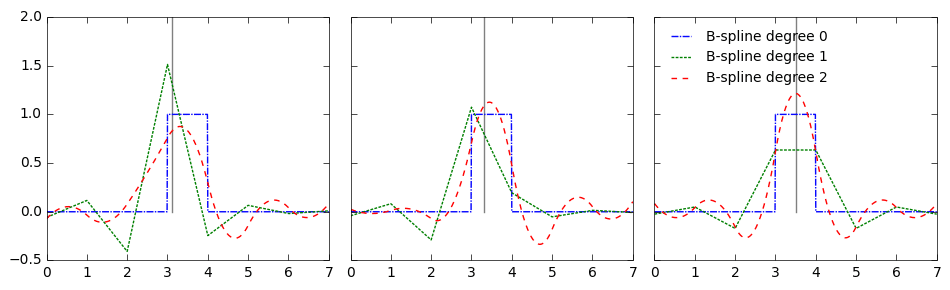

In [28]:
grid_size = 8  # use a larger grid to illustrate the wings of the B-spline approximation
grid_nodes = numpy.linspace(0, 7, grid_size)
x = numpy.linspace(grid_nodes[0], grid_nodes[-1], 100*(grid_size-1)+1)

def compute_projection_deltafnc(x0, ax):
    # for a delta-function, its projection onto the basis is just the values of basis functions at x0
    ax.plot([x0, x0], [0, 2], color='gray')
    return lambda basis_fncs: [basis_fnc(x0) for basis_fnc in basis_fncs]

ax = plt.subplots(1, 3, figsize=(9.6,3), sharex=True, sharey=True)[1]
show_three_bspline_approximations(ax[0], compute_projection_deltafnc(3.1, ax[0]))
show_three_bspline_approximations(ax[1], compute_projection_deltafnc(3.3, ax[1]))
show_three_bspline_approximations(ax[2], compute_projection_deltafnc(3.5, ax[2]))
ax[2].legend(loc='upper left', frameon=False, fontsize=10)
ax[0].set_xticks(grid_nodes)
ax[0].set_xlim(min(grid_nodes), max(grid_nodes))
ax[0].set_ylim(-0.5, 2.0)
plt.tight_layout()

#### Back to discretization schemes

So the two variants of "Classic" and "Cylindrical" density discretization schemes, "TopHat" and "Linear", differ in the degree of B-splines they use for the weighting functions. In the "Linear" variants, a direct product of 1d B-splines of degree 1 is used to associate the mass with grid nodes, rather than grid cells; the integration is carried over two adjacent grid segments in each dimension. These variants should be preferred, since they can both better approximate the smooth input density profile, and resolve the details within grid cells for the orbit-superposition model. For instance, if two orbits have somewhat different spatial extent, but are both confined within one grid cell, the "TopHat" scheme would not distinguish them, whereas "Linear" will be able to assign them different weights depending on the variation of the input density profile within the cell.<br>
It should be stressed that despite the oscillatory nature of higher-degree spline approximations for individual orbits (since they have sharp boundaries), the weighted sum of all orbits still matches the density profile represented by the same spline basis, so should be as smooth as the input density profile.

The `KinemShell` target type is also based on B-splines in radius, and in the above example, we selected degree-1 (linear) B-splines; choices range from 0 to 3, but the advantage of the degree-1 version is that the number of basis functions equals the number of grid nodes, making it easier to specify the required anisotropy profile (with higher-degree B-splines, one would have to go through the projection and matrix inversion process). Note, however, that B-splines are used to represent the integrals $\int \rho\,\sigma_\text{rad,tan}^2\,r^2\;dr$, rather than the anisotropy coefficient $\beta$ (the latter is a ratio of two spline interpolators); nevertheless, providing the $\beta(r)$ profile as the the values at radial grid nodes is a sensible interpretation.

A technical detail is that the values returned by `Target` applied to either a density profile or an orbit are *projections* $\boldsymbol P$ of the profile onto the basis, rather than *amplitudes* $\boldsymbol a$ of a B-spline representation (as explained above, one is obtained from the other by multiplication by a non-degenerate matrix $\mathsf{M}$). Since the linear superposition attempts to match the projection of the density profile by a sum of projections of each orbit, it does not matter whether we multiply both sides by $\mathsf{M}^{-1}$.

B-splines are also heavily used in the third kind of `Target` objects, `LOSVD`, which will be discussed later in the context of observational applications.

#### Further considerations

##### Initial conditions for the orbit library

In the earlier example, we created the initial conditions by assigning velocities isotropically, using the Eddington-derived DF for a sphericalized input density/potential pair. This may be sufficient for spheroidal systems (even with significant amounts of triaxiality), but in case of disky components, isotropic velocity assignment would be very inefficient, since most orbits will not stay close to the equatorial plane and would not be picked up by the optimization solver.<br>
An alternative approach is based on the auxiliary axisymmetric Jeans model constructed for the given input density/potential pair (using the cylindrically-aligned anisotropic Jeans equations as given, e.g., by eqs 8-11 in [Cappellari 2008](http://adsabs.harvard.edu/abs/2008MNRAS.390...71C); the anisotropy in the meridional plane is controlled by the parameter $\beta_\text{mer} \equiv 1 - \sigma_z^2/\sigma_R^2$). From this model, we obtain the full second moments of velocity in cylindrical coordinates; the $R$ and $z$ components are just the corresponding velocity dispersions, but for the $\overline {v_\phi^2}$ component we have some freedom in splitting it between ordered and random motions, which is controlled by another parameter $\kappa$ ranging from 0 (no net rotation) to $\pm 1$ (near-maximum rotation in either prograde or retrograde direction). Finally, velocities are drawn from a Gaussian distribution with the given dispersions.<br>
This approach is triggered by providing two extra parameters to the `sample` method of the Density class:

In [29]:
ic_rot, _ = dens_stars.sample(num_orbits, potential=pot_total, beta=0, kappa=1)

One can verify that these initial conditions indeed have some net rotation (stronger in the very central part due to the presence of the BH).

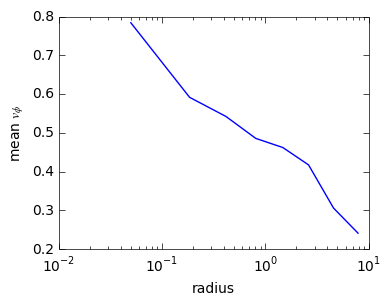

In [30]:
ic_rot_R = (ic_rot[:,0]**2 + ic_rot[:,1]**2)**0.5
ic_rot_vphi = (ic_rot[:,0] * ic_rot[:,4] - ic_rot[:,1] * ic_rot[:,3]) / ic_rot_R
mean_vphi = (numpy.histogram(ic_rot_R, bins=gridR, weights=ic_rot_vphi)[0] /
             numpy.histogram(ic_rot_R, bins=gridR)[0])
plt.figure(figsize=(4,3))
plt.plot(0.5*(gridR[1:]+gridR[:-1]), mean_vphi)
plt.xlabel('radius')
plt.ylabel(r'mean $v_\phi$')
plt.xscale('log')

When building the orbit library with these rotating initial conditions and solving for orbit weights without providing any kinematic constraints, the model ends up being tangentially anisotropic and rotating, as expected. However, it is not difficult to force it to have a desired anisotropy profile (even radial) using the `solve_with_beta_profile` function defined earler. This highlights that when providing kinematic constraints, the choice of orbital initial conditions does not play a major role in the properties of the resulting model; however, a poor choice may require a much larger number of orbits to adequately satisfy the constraints, and most of these orbits would receive zero weight and thus will be wasted.<br>
This brings us to the next topic:

##### Size of the orbit library

A short answer is: more is always better. Of course, if the number of orbits is less than the number of constraints, it would be impossible to satisfy the constraints exactly, so it is recommended that $N_\text{orbits}$ exceeds $N_\text{constraints}$ by a factor of a few ([Valluri+2004](http://adsabs.harvard.edu/abs/2004ApJ...602...66V) advocate at least 5–10$\times$). Even in this case some density constraints may not be possible to satisfy exactly, requiring one to assign some finite uncertainty to them, and in observational applications, kinematic constraints also always have some uncertainty. As usual, it is advisable to carry out convergence tests with larger number of orbits to see if the model properties are reasonably stable.

One current limitation is that the total size of all $\mathsf{D}^{(k)}$ matrices passed to the CVXOPT optimization solver cannot exceed $2^{31}$. This looks like a huge number, but in fact for observational datasets coming from large IFUs like MUSE, it is not uncommon to have $N_\text{constraints}$ in the range of few $\times10^4$, and if one tries to match this by setting $N_\text{orbits}\gtrsim 10^5$, this would exceed the limit. When the number of $N_\text{constraints}$ *with uncertainties* exceeds $0.5 N_\text{orbits}$, the code chooses a different strategy for assembling the matrices, with the result that the number of orbits becomes the limiting factor – it may not exceed $\sqrt{2^{31}} \approx 46\,000$. But in the more common situation when the number of constraints is not enormous, one can easily have $N_\text{orbits}\ge 10^5$, although one is usually well served by a number a few times smaller.

##### Distribution of orbit weights

As already mentioned, the distribution of orbit weights is a valuable sanity check on the model. One could expect it to be somewhat broad, with a large fraction of orbits receiving weights of order $M_\text{total} / N_\text{orbits}$, but occasional higher-weight outliers may pop up. If not too distant from the bulk of the distribution, these may be acceptable, but it would certainly be a major concern if one orbit contributes more than a few percent of the total mass – the method relies on the smooth DF being approximated by a collection of discrete  orbits, so no single one should stand out much.<br>
One can examine various "quality metrics" for the orbit weights distribution, for instance:

In [31]:
def analyze_weights(weights):
    total_mass = numpy.sum(weights)
    normalized_weights = weights * len(weights) / total_mass  # weights normalized by their mean value
    # high-weight outliers
    print('max weight (closer to unity = better): %.3g' % numpy.max(normalized_weights))
    # overall width of the weight distribution
    print('mean square weight (closer to unity = better): %.3g' % numpy.mean(normalized_weights**2))
    # another measure of uniformity of the weight distribution (all weights equal => entropy=0)
    print('entropy of weight distribution (less negative = better): %.3g' %
        numpy.mean(-normalized_weights * numpy.log(normalized_weights+1e-100)))
    # number of "useful" orbits in the model - if much smaller than the corresponding mass fraction (90%),
    # it means that many orbits were not included into the superposition and therefore are wasted
    print('fraction of orbits contributing 90%% of total mass (more = better): %i/%i' %
        (numpy.searchsorted(numpy.cumsum(numpy.sort(weights)[::-1]), 0.9*total_mass), len(weights)))

analyze_weights(weights)

max weight (closer to unity = better): 25.9
mean square weight (closer to unity = better): 2.15
entropy of weight distribution (less negative = better): -0.211
fraction of orbits contributing 90% of total mass (more = better): 1554/2000


##### Regularization

One can promote EDI in the orbit library by adding another term in the objective function $\mathcal Q$ that penalizes non-uniform weight distributions. A simple choice compatible with the quadratic structure of the problem is to use a sum of squared orbit weights as a penalty; since the sum of all weights is fixed to the total mass, the sum of their squares is indeed minimized when the weights are equal. This corresponds to adding some positive regularization coefficient $\lambda$ to diagonal elements of the matrix $\mathsf Q$, and is achieved by passing a vector `xpenq=...` to the `solveOpt` routine. If all constraints are required to be satisfied exactly, this quadratic penalty is the only term in the objective function, so the particular value of $\lambda$ does not matter (it just rescales the value of $\mathcal Q$). However, if there are some inexact constraints with associated finite penalties `rpenq` (as is always the case in observational applications), the minimization of the single scalar function $\mathcal Q$ has to balance two conflicting requirements – making weights more uniform will likely increase deviations from constraint values, and vice versa.<br>
So by changing the value of the regularization parameter $\lambda$, one can shift the balance between these two factors. As usual, one should try different values, examine how they affect the properties of the solution (deviations in constraints vs. quality metrics for the orbit weights distribution), and find an optimum for a particular situation.<br>
Regularization will be further discussed in the second part of this tutorial.

##### Troubleshooting the density constraints

The density constraints are responsible for maintaining the dynamical self-consistency of the model, ensuring that the sum of orbits reproduces the gravitational potential in which they were computed.
So it makes sense to require these constraints to be satisfied exactly.
Moreover, in observational applications, the kinematic constraints come with measurement uncertainties, and the model is fitted to observations in the least-square sense; the difference between the model and the data (i.e. $\chi^2$) is used to as a measure of the fit quality, so it is convenient if the gravitational self-consistency constraints on cell masses do not contribute to the $\chi^2$ value (as happens when they are presented as exact constraints).

However, the optimization solver may fail to find the exact match to the discretized density profile, necessitating to assign some arbitrary nonzero uncertainty (say, a few percent) to cell masses.
This usually indicates that some constraints imposed on the model are unrealistic, and could be caused either by a poor choice of numerical parameters of the model (inadequate grids, too small number of orbits, etc.), or by the unphysical properties of the model (like a density profile with an inner hole, or a triaxial bar extending well beyond corotation radius).<br>
For instance, the grid chosen for discretizing the density profile might not be adequate if some cells have very few (if any) orbits visiting them, usually at very small or very large radii. Often it may be fixed by simply increasing the number of orbits, but one may need to rethink the placement of grid nodes and/or the assignment of initial conditions for the orbit library.
Sometimes one does need to have a very fine grid at small radii (e.g. in models with a central BH whose mass is a small fraction of the total galaxy mass, we still need to resolve the sphere of influence with at least a few grid cells); in this case, it may be useful to augment the usual array of initial conditions sampled from the entire density profile with a second array sampled from an auxiliary, more centrally concentrated profile.<br>
In any case, the failure to satisfy the density constraints exactly (or as a milder symptom of difficulty, a solution with a few orbits getting very high weights, and the majority getting near-zero weights) requires some follow-up analysis to decide if this situation is acceptable.

### Part 2: observational applications

When using the Schwarzschild method to fit dynamical models to observational data, there are several additional ingredients in the workflow.
Almost all current applications of the method are tailored to external galaxies, which has the following implications:
- The galaxy is assumed to be distant enough that one can use an orthogonal projection onto the sky plane (i.e. ignore perspective effects). 
- The observed kinematic data represent unresolved stellar populations, and come in the form of line-of-sight velocity distributions (LOSVD) in a number of spatial regions ("apertures") on the 2d sky plane. In many cases, these apertures are pixels of a 2d grid of an integral-field spectroscopic unit (IFU); the LOSVDs are determined in individual pixels, or in groups of adjacent pixels, usually constructed with the Voronoi binning method ([Cappellari&Copin 2003](http://adsabs.harvard.edu/abs/2003MNRAS.342..345C)). In earlier studies, the kinematic data were taken using long-slit spectrographs, thus come in the form of one-dimensional profiles (effectively, IFUs with one row of pixels). Other possibilities include circular fibers arranged in a hexagonal grid (e.g. in the MaNGa survey). In general, the kinematic properties in the model are recorded as a 3d datacube (two spatial and one velocity dimension) and then binned into the apertures, defined as arbitrary polygons on the sky plane.
- Due to finite spatial resolution, the LOSVD in a given aperture has contributions from nearby regions in the galaxy; in other words, the kinematic maps in the model need to be convolved with the instrumental point-spread function (PSF) before comparing them to the data.
- By contrast, the velocity dimension of the LOSVD represents the actual velocity distribution deconvolved from instrumental effects during the spectral data reduction stage. Often (but not always) LOSVDs come in the form of Gauss–Hermite expansions, but other options include a histogrammed representation, and in principle could be even more general (e.g. B-splines of higher degree).
- A common feature in spectroscopic data reduction is that LOSVDs are unnormalized by amplitude; in other words, we know what is the relative fraction of stars with different velocities, but not their total number in the given aperture. This information comes from photometry, usually derived separately with a different instrument and pipeline.
- Of course, photometric information is limited to the 2d sky plane, so in order to construct the 3d density model and the associated potential, one needs to deproject the surface brightness profile. Obviously, this is not a uniquely defined solution (see [Gerhard&Binney 1996](http://adsabs.harvard.edu/abs/1996MNRAS.279..993G), [Kochanek&Rybicki 1996](http://adsabs.harvard.edu/abs/1996MNRAS.280.1257K), and more recently [de Nicola+2020](http://adsabs.harvard.edu/abs/2020MNRAS.496.3076D) for discussions). However, for a special class of *ellipsoidally stratified* density profiles (e.g. a triaxial `Spheroid` model), the relation between the intrinsic shape, projected ellipticity, and viewing angles *is* unique (or rather, has at most four possible choices of angles, see the interactive illustration in `example_deprojection.py`). Thus in practice, most studies sidestep the degeneracies in deprojection by using ellipsoidal profiles, for instance, the Multi-Gaussian expansion ([Emsellem+1994](http://adsabs.harvard.edu/abs/1994A&A...285..723E), [Cappellari 2002](http://adsabs.harvard.edu/abs/2002MNRAS.333..400C)), in which the surface density is represented by a sum of many elliptical Gaussian components with different sizes and possibly orientations. Under the assumption that the 3d density is also composed of 3d ellipsoidal Gaussians (which do project into 2d Gaussians) sharing the same principal axes directions, but having different axis ratios, for a given choice of viewing angles one can either derive a unique solution or deprojection is impossible.<br>

The goal of observationally-focused Schwarzschild modelling is to constrain some properties of the galaxy, in particular the mass distribution and possibly orientation, by exploring a range of models and fitting them to the observational data. 
We will completely ignore the question of deprojection and assume that the 3d stellar density profile is known (for a given orientation) up to some normalization factor (mass-to-light ratio M/L=$\Upsilon$), which is usually one of the parameters constrained during the modelling procedure. In addition to stars, which both contribute to the total potential and produce observed kinematic maps, there may be one or more invisible mass components, such as the central supermassive black hole (BH) or the dark halo; their parameters are also constrained during modelling.

The modelling workflow consists of the following steps:
1. Adopt the 3d density profile of stars (likely depends on the galaxy orientation).
2. Adopt other parameters controlling the gravitational potential (BH mass or dark halo properties).
3. Construct the total gravitational potential $\Phi$.
4. Construct the orbit library in this potential.
5. Solve the optimization problem to determine the orbit weights $\boldsymbol w$ that reproduce the 3d density profile while minimizing $\chi^2$ (sum of error-normalized squared deviations in kinematic maps between the data and the model).
6. Repeat from steps 1 or 2 for different choices of potential parameters and find the ones that have the lowest overall $\chi^2$.



#### Basic example

In the observational part of this tutorial, we will use mock data rather than real observations, and limit ourselves to a very simple system – a spherical density profile of stars (same as in the theoretical part, but spherical), plus a central BH. The motivation is that in these models, the DF can be found easily through the Eddington inversion formula or its anisotropic generalizations, and thus it is straightforward to create mock data.<br>
Moreover, we keep the "theoretical" unitless convention, in which $G=1$, and choose model parameters (mass, size and characteristic velocity dispersion) to be of order unity.

We create a `QuasiSpherical` DF for the given density and potential, adding rotation about the $z$ axis through `rotFrac` and `Jphi0` parameters. This more closely resembles actual galaxies modelled with the Schwarzschild method in axisymmetric geometry, which usually have some rotation.

We will further assume that the 3d density profile is known (in spherical systems, it can be uniquely determined from the observed surface brightness profile), and the galaxy is observed "edge-on", that is the rotation axis $z$ lies in the sky plane, which gives the maximum amount of rotation in the line-of-sight velocities.

In [32]:
total_mass   = 1.0  # mass of stars
true_bh_mass = 0.1  # mass of the central black hole
# density profile with a mild central cusp and a steeper fall-off than either NFW or Hernquist profiles
true_pot_stars = agama.Potential(type='Spheroid', gamma=1, beta=5, mass=total_mass, scaleRadius=1)
# as before, making the distinction between density of tracers and their contribution to the total potential
true_dens_stars = true_pot_stars
# total potential of stars and BH
true_potential = true_pot_stars + agama.Potential(type='Plummer', mass=true_bh_mass, scaleRadius=1e-6)
# anisotropy parameter beta0 (assumed constant with radius) of the QuasiSpherical DF;
# for a density profile r^-gamma in the Kepler potential, beta0 <= gamma-1/2 (i.e. <= 0.5 in our case),
# and beta0 should be >= -0.5 for a QuasiSpherical DF in general.
# However, an extreme alternative is beta0 = -infinity (all stars on circular orbits), which is treated separately
beta0 = -0.2
# draw a large number of particles from this DF, which will be used to create kinematic maps
num_samples = int(1e7)
if beta0 >= -0.5 and beta0 <= 0.5:
    # DF with some rotation
    true_df_stars = agama.DistributionFunction(
        type='QuasiSpherical',
        density=true_dens_stars,
        potential=true_potential,
        beta0=beta0,
        r_a=numpy.inf,
        rotFrac=1.0,  # max rotation
        Jphi0=0.5)
    gm = agama.GalaxyModel(true_potential, true_df_stars)
    snapshot = gm.sample(num_samples)
elif beta0 == -numpy.inf:
    # use a different approach: first sample positions from the density profile
    snap_pos, snap_mass = true_dens_stars.sample(num_samples)
    snap_r = numpy.sum(snap_pos**2, axis=1)**0.5
    # for each particle, assign velocity to be perpendicular to the radius-vector
    # with magnitude equal to the local circular velocity (no preferred rotation)
    snap_vcirc = numpy.sum(-true_potential.force(snap_pos) * snap_pos, axis=1)**0.5
    phi = numpy.random.random(num_samples) * 2*numpy.pi
    sinphi, cosphi = numpy.sin(phi), numpy.cos(phi)
    snap_vel = snap_vcirc[:,None] * numpy.column_stack([
        -(snap_pos[:,1]**2 + snap_pos[:,2]**2) * sinphi,
        snap_pos[:,0] * snap_pos[:,1] * sinphi - snap_r * snap_pos[:,2] * cosphi,
        snap_pos[:,0] * snap_pos[:,2] * sinphi + snap_r * snap_pos[:,1] * cosphi
    ]) / (snap_r * (snap_pos[:,1]**2 + snap_pos[:,2]**2)**0.5)[:,None]
    snapshot = (numpy.column_stack((snap_pos, snap_vel)), snap_mass)
else:
    raise RuntimeError("invalid value of beta0")

#### Coordinates

As explained earlier, the method is usually applied to distant external galaxies, so in the current implementation the conversion from the intrinsic model coordinates $xyz$ and the observed coordinates $XYZ$ is a simple 3d rotation parametrized by Euler angles $\alpha\beta\gamma$ (see Section A.3 in `reference.pdf` for definitions and an illustration, which is reproduced below). For axisymmetric systems, we only need two angles: $\beta$ is the inclination (unfortunately the same letter also denotes the outer slope of the `Spheroid` density profile and the velocity anisotropy parameter of the `QuasiSpherical` DF, but hopefully the usage will be clear from the context), and $\gamma$ is the angle between the line of nodes and the $X$ axis of the observed coordinate system. The line of nodes is the intersection between the $xy$ (equatorial) plane of the model and the sky plane ($XY$), which in axisymmetric systems is the axis with the maximum amplitude of rotation. We will start by setting $\gamma=0$, i.e. aligning $x$ with $X$.<br>
Another important detail is that the $Z$ axis (line of sight) points *away* from the observer to match the convention that positive line-of-sight velocity is redshifted (object moves away). Thus to keep the coordinate system $XYZ$ right-handed, we have to orient the $X$ axis leftward (and keep the $Y$ axis pointing upward).

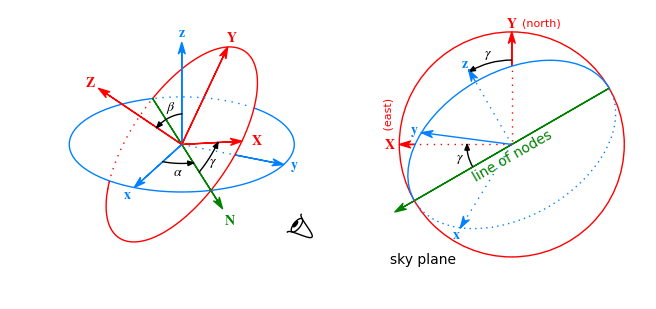

In [33]:
def draw_angles_illustration():
    sin = numpy.sin
    cos = numpy.cos
    pi  = numpy.pi
    alpha = 40*pi/180
    beta  = 50*pi/180
    gamma = 30*pi/180
    mat = agama.makeRotationMatrix(alpha, beta, gamma)

    def drawarrow(path, color, dashes=None, head_length=0.1, head_width=0.06, overhang=0.3):
        l=ax.plot(path[:,0], path[:,1], color=color)[0]
        if dashes is not None: l.set_dashes(dashes)
        ax.arrow(path[-1,0], path[-1,1], (path[-1,0]-path[-2,0])*1e-5, (path[-1,1]-path[-2,1])*1e-5,
            color=color, head_length=head_length, head_width=head_width, overhang=overhang, length_includes_head=True)

    plt.figure(figsize=(6, 2.7))

    ax = plt.axes([0, 0, 0.45, 1])
    ax.set_axis_off()
    azim, elev = 25, 25
    matv = agama.makeRotationMatrix((azim+90)*pi/180, (90-elev)*pi/180, 0)
    mat0 = agama.makeRotationMatrix(alpha, beta, 0)
    angs = numpy.linspace(0, 2*pi, 181);
    sa   = sin(angs)
    ca   = cos(angs)
    xyp  = numpy.column_stack((ca*cos(alpha)-sa*sin(alpha), sa*cos(alpha)+ca*sin(alpha), sa*0))  # xy plane
    XYp  = mat0.T.dot(numpy.vstack((ca, sa, sa*0))).T
    x,y,z= numpy.eye(3)
    X,Y,Z= mat
    xyv  = xyp.dot(matv.T)
    XYv  = XYp.dot(matv.T)
    xyza = matv.T
    XYZa = mat.dot(matv.T)
    Na   = numpy.array([cos(alpha), sin(alpha), 0]).dot(matv.T)
    angs = numpy.linspace(0, 1, 9)
    curva= 0.4*numpy.column_stack([cos(angs*alpha), sin(angs*alpha), angs*0]).dot(matv.T)
    curvb= 0.3*numpy.column_stack([sin(angs*beta)*sin(alpha), -sin(angs*beta)*cos(alpha), cos(angs*beta)]).dot(matv.T)
    curvg= 0.6*numpy.column_stack([cos(angs*gamma), -sin(angs*gamma), angs*0])[::-1].dot(mat).dot(matv.T)
    ax.add_artist(matplotlib.patches.Polygon(xyv[:91,0:2], closed=False, fill=False, ec='#0080FF'))
    ax.arrow(0,0, xyza[1,0], xyza[1,1], color='#0080FF', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.add_artist(matplotlib.patches.Polygon(XYv[:91,0:2], closed=False, fill=True,  ec='r', color='white'))
    ax.add_artist(matplotlib.patches.Polygon(XYv[90:,0:2], closed=False, fill=False, ec='r'))
    ax.add_artist(matplotlib.patches.Polygon(xyv[90:,0:2], closed=False, fill=True,  ec='#0080FF', color='white'))
    ax.plot(xyv[65:91 ,0], xyv[65:91 ,1], color='#0080FF', dashes=[1,4])
    ax.plot(XYv[91:120,0], XYv[91:120,1], color='r', dashes=[1,4])
    ax.plot([0,xyza[1,0]*0.5], [0,xyza[1,1]*0.5], color='#0080FF', dashes=[1,4])
    ax.arrow(-Na[0], -Na[1], Na[0]*2.4, Na[1]*2.4, color='g', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0,0, xyza[0,0], xyza[0,1], color='#0080FF', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0,0, xyza[2,0], xyza[2,1], color='#0080FF', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0,0, XYZa[0,0], XYZa[0,1], color='r', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0,0, XYZa[1,0], XYZa[1,1], color='r', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0,0, XYZa[2,0], XYZa[2,1], color='r', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    drawarrow(curva, 'black', head_length=0.05, head_width=0.04, overhang=0)
    drawarrow(curvb, 'black', head_length=0.05, head_width=0.04, overhang=0)
    drawarrow(curvg, 'black', head_length=0.05, head_width=0.04, overhang=0)
    ax.text(curva[4,0], curva[4,1]-0.01, r'$\alpha$', color='black', ha='center', va='top')
    ax.text(curvb[3,0], curvb[3,1]+0.01, r'$\beta$' , color='black', ha='center', va='bottom')
    ax.text(curvg[4,0], curvg[4,1]+0.02, r'$\gamma$', color='black', ha='left', va='top')
    ax.text(xyza[0,0]*1.15,xyza[0,1]*1.15,r'$\mathbf{x}$', ha='center', va='center', color='#0080FF')
    ax.text(xyza[1,0]*1.1, xyza[1,1]*1.1, r'$\mathbf{y}$', ha='center', va='center', color='#0080FF')
    ax.text(xyza[2,0]*1.1, xyza[2,1]*1.1, r'$\mathbf{z}$', ha='center', va='center', color='#0080FF')
    ax.text(XYZa[0,0]*1.25,XYZa[0,1]*1.25,r'$\mathbf{X}$', ha='center', va='center', color='r')
    ax.text(XYZa[1,0]*1.1, XYZa[1,1]*1.1, r'$\mathbf{Y}$', ha='center', va='center', color='r')
    ax.text(XYZa[2,0]*1.1, XYZa[2,1]*1.1, r'$\mathbf{Z}$', ha='center', va='center', color='r')
    ax.text(Na[0]*1.65, Na[1]*1.65, r'$\mathbf{N}$', ha='center', va='center', color='g')

    def drawEye(x, y, size, color='k', lw=1, angle=0):
        t = numpy.linspace(-1,1,51)
        u = -size * numpy.cos(t*numpy.pi/2)**2
        v = size*t/2
        a = angle*pi/180
        ax.plot(x + u*cos(a)-v*sin(a), y+v*cos(a)+u*sin(a), color=color, linewidth=lw)
        p = -size*0.15
        ax.add_artist(matplotlib.patches.Ellipse((x + p*cos(a), y + p*sin(a)), size*0.30, size*0.735, color=color, fill=False, linewidth=lw, angle=angle))
        p = -size*0.06
        ax.add_artist(matplotlib.patches.Ellipse((x + p*cos(a), y + p*sin(a)), size*0.12, size*0.300, color=color, fill=True, angle=angle))

    drawEye(1.0, -0.7, 0.2, angle=142)
    ax.set_xlim(-1.2, 1.2)
    ax.set_ylim(-1.2, 1.2)

    ax = plt.axes([0.55, 0, 0.45, 1])
    ax.set_axis_off()
    drawarrow(numpy.array([[0,0], mat[0:2,0]]), color='#0080FF', dashes=[1,4])
    drawarrow(numpy.array([[0,0], mat[0:2,1]]), color='#0080FF')
    drawarrow(numpy.array([mat[0:2,2]*0.85, mat[0:2,2]]), color='#0080FF')
    ax.plot([0,mat[0,2]*0.85], [0,mat[1,2]*0.85], color='#0080FF', dashes=[1,4])
    ax.arrow(0.86, 0, 0.14, 0, color='r', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.arrow(0, 0.70, 0, 0.30, color='r', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.plot([0.01,0.86], [0,0], color='r', dashes=[1,4])
    ax.plot([0,0], [0.03,0.70], color='r', dashes=[1,4])
    ax.arrow(-cos(gamma), sin(gamma), 2.2*cos(gamma), -2.2*sin(gamma), color='g', head_length=0.1, head_width=0.06, overhang=0.3, length_includes_head=True)
    ax.text(0, -0.1, 'line of nodes', ha='center', va='center', rotation=gamma*180/pi, color='g')
    ax.text(mat[0][0]*1.08, mat[1][0]*1.08, r'$\mathbf{x}$', color='#0080FF', ha='center', va='center')
    ax.text(mat[0][1]*1.08, mat[1][1]*1.08, r'$\mathbf{y}$', color='#0080FF', ha='center', va='center')
    ax.text(mat[0][2]*1.08, mat[1][2]*1.08, r'$\mathbf{z}$', color='#0080FF', ha='center', va='center')
    ax.text(1.08, 0, r'$\mathbf{X}$', color='r', ha='center', va='center')
    ax.text(0, 1.08, r'$\mathbf{Y}$', color='r', ha='center', va='center')
    ax.text(-0.1, 1.05, '(north)', color='r', fontsize=8, ha='left')
    ax.text(1.05, 0.1,  ' (east)', color='r', fontsize=8, va='bottom', ha='right', rotation=90)
    ax.add_artist(matplotlib.patches.Circle((0,0), radius=1, color='r', fill=False))
    ax.add_artist(matplotlib.patches.Arc((0,0), width=2, height=2*cos(beta), angle=-gamma*180/pi, color='#0080FF', theta1=0.0, theta2=180))
    ax.add_artist(matplotlib.patches.Arc((0,0), width=2, height=2*cos(beta), angle=-gamma*180/pi, color='#0080FF', theta1=180, theta2=360, linestyle=(0,(1,3))))
    ax.add_artist(matplotlib.patches.Arc((0,0), width=0.8, height=0.8, theta1=  -gamma*180/pi, theta2= 0, color='black'))
    ax.add_artist(matplotlib.patches.Arc((0,0), width=1.5, height=1.5, theta1=90-gamma*180/pi, theta2=90, color='black'))
    ax.arrow(0.397, 0, 0, 1e-4, head_length=0.05, head_width=0.04, color='black', length_includes_head=True)
    ax.arrow(sin(gamma)*0.75, cos(gamma)*0.75, cos(gamma)*1e-4, -sin(gamma)*1e-4, head_length=0.05, head_width=0.04, color='black', length_includes_head=True)
    ax.text(0.48*cos(gamma/2), -0.48*sin(gamma/2), r'$\gamma$', color='black', ha='center', va='center')
    ax.text(0.83*sin(gamma/2),  0.83*cos(gamma/2), r'$\gamma$', color='black', ha='center', va='center')
    ax.set_xlim(1.2, -1.2)
    ax.set_ylim(-1.2, 1.2)
    ax.text(0.05, 0.05, 'sky plane', transform=ax.transAxes, ha='left', va='bottom')

draw_angles_illustration()

#### Kinematic target for LOSVD

The `KinemShell` target introduced in the first part of this tutorial is not intended for observational modelling. For this task we need another type of Target named `LOSVD`, which records kinematic data of orbits on a 3d grid in the space of two sky coordinates $X,Y$ and the line-of-sight velocity $v_Z$. In fact, we do not need these data at arbitrary locations $X,Y$ on the sky plane; rather, what is compared to observations are the LOSVDs $\mathfrak{f}_b(v_Z)$ integrated over the area of each aperture $A_b$ (or even more precisely, first convolved with the instrumental PSF $K$ in $X,Y$ and then integrated):<br>
$\displaystyle \mathfrak f_b(v_Z) = \iint_{X,Y \in A_b} dX\,dY\; f(X', Y', v_Z)\; K_{2d}(X-X',Y-Y')$.

This discretization scheme is also based on B-splines, but unlike the other Target types, the values stored for each orbit are not its *projections* onto the basis functions, but *amplitudes* of the B-spline representation of LOSVD in each spatial region (aperture). This is convenient because one can directly use these amplitudes to reconstruct the LOSVD, or further convert them to a Gauss–Hermite expansion, as will be discussed later.

Apertures can have arbitrary shapes and locations (they are specified by polygons), but it would be cumbersome to deal with this general representation when collecting data during orbit integration. Instead, the process is split in two stages:
- The kinematic datacube for each orbit is first recorded as a projection onto a 3d B-spline basis (a tensor product of 1d B-splines in $X, Y, v_Z$).
- At the end of orbit integration this datacube is converted into a 2d array $\mathsf{a}$: for each aperture $b$, it contains the vector of amplitudes $\boldsymbol{a}_b$ of a 1d B-spline representation of LOSVD $\mathfrak f_b(v_Z) = \sum_i a_{b,i} F_i(v_Z)$, where $F_i(v_Z)$ are B-spline basis functions in velocity. This step implements both the convolution with the PSF and rebinning (integration over the area of each aperture), both performed analytically for the B-spline functions in $X,Y$. A technical detail is that the convolution is performed separately in each spatial dimension; this limits the choice of kernel $K$ to a 2d Gaussian (or a sum of several circular Gaussians with different widths, which offer sufficient flexibility in practice).

The 2d array of amplitudes for each orbit is reshaped into a 1d vector of length $N_\text{apertures}\times N_\text{basis}$; stacked together, these arrays are returned by the `orbit()` function as a result of applying the `LOSVD` target to the orbit library. This matches the convention used by other Target types: even when discretizing the orbit on a 3d spatial density grid, the result is stored as a single row for each orbit.

In the optimization problem, we obtain the orbit weights $\boldsymbol w$ by solving the linear system of equations $\mathsf{D} \boldsymbol w = \boldsymbol r$. For a `Density***` target, both the matrix $\mathsf{D}$ and the right-hand side vector $\boldsymbol r$ are obtained by applying this target to the orbit library and to the input density profile, respectively. However, recall that for a `KinemShell` target we needed to convert the matrix $\mathsf{C}$ returned by the orbit integration routine into a transformed matrix $\mathsf{D}$ that is passed to the optimization solver. The same procedure is used with the `LOSVD` target, since we typically do not compare the B-spline representations of the LOSVD directly to observations, but use another representation for the latter (e.g. the Gauss–Hermite expansion).

Anyhow, to establish the `LOSVD` target, we need to specify both the list of apertures and the parameters of the internal 3d B-spline grid. Let's start with the former.<br>
In the first example, we consider one-dimensional kinematic profiles, as would be produced by long-slit spectroscopic observations. The slit is positioned along the line of nodes, maximizing the rotation amplitude. We set the slit width to 0.1 and create 15 bins of length ranging from 0.1 in the central bin to ~0.5 in the outermost bins.

In [34]:
# flip the sign to have the aperture indices increase from left to right
gridx_slit = -agama.symmetricGrid(16, 0.1, 2.0)
gridy_slit = [-0.05, 0.05]
apertures = [
    [[gridx_slit[i],   gridy_slit[0]],
     [gridx_slit[i],   gridy_slit[1]],
     [gridx_slit[i+1], gridy_slit[1]],
     [gridx_slit[i+1], gridy_slit[0]]]
    for i in range(len(gridx_slit)-1) ]
print('aperture boundaries in X: %s' % numpy.array2string(gridx_slit, precision=3, max_line_width=999))

XY_aperture_centers = numpy.column_stack([
    (gridx_slit[1:] + gridx_slit[:-1])*0.5,
    numpy.zeros((len(gridx_slit)-1,)) ])

aperture boundaries in X: [ 2.     1.486  1.083  0.767  0.518  0.323  0.17   0.05  -0.05  -0.17  -0.323 -0.518 -0.767 -1.083 -1.486 -2.   ]


Next we specify the parameters for the `LOSVD` Target. The B-spline degree can range from 0 to 3 (with higher degrees providing better accuracy of interpolation and convolution, see figure 5 in the appendix of the Forstand paper), but in practice a degree 2 is a good tradeoff between accuracy and computational cost.<br>
The 2d grid in $X,Y$ should at minimum cover all apertures, and ideally extend a few pixels beyond the footprint of kinematic data. Its pixel size needs to be comparable or smaller than either the size of apertures or the width of the Gaussian PSF (in our example, 0.1), whichever is larger. In principle, the B-spline grid in $X$, $Y$ and $v_Z$ needs not be uniform; for example, in a typical scenario when smaller apertures are used for central regions and larger (Voronoi-binned) apertures for the outer parts, one can set up B-spline grids with smaller pixels in the center (e.g. using `agama.nonuniformGrid` or `agama.symmetricGrid`); ideally the size of the grid in each dimension should not exceed few tens to a hundred, so uniform grids would not be practical for very large IFU datasets, such as coming from MUSE.<br>
The velocity grid in should cover the range of $v_Z$ expected in the entire model (e.g. $\pm$ the escape velocity from the central region, or at least $3\times$ the highest value of velocity dispersion) and have grid spacing around $0.5\times$ the lowest value of velocity dispersion in the dataset (*adjusted for $\Upsilon$, as will be explained later*); typically a grid with 25–50 points satisfies these requirements. If these relatively coarse grid sizes come as a surprise, it is the use of higher-degree B-splines that makes them accurate enough in practical applications; one would indeed need much larger grids if using histograms (degree 0), which is almost never advisable.<br>
Finally, we need to specify the inclination of the galaxy and the symmetry of the model (in our case, axisymmetric, even though the density profile is spherical, but added rotation breaks this symmetry).

In [35]:
beta_incl = numpy.pi/2  # 90degrees = edge-on
gridx_kin = numpy.linspace(-2.2, 2.2, 51)
gridy_kin = numpy.linspace(-0.3, 0.3, 7)
gridv_kin = numpy.linspace(-2.5, 2.5, 26)
degree_kin = 2
psf = 0.1
target_losvd = agama.Target(
    type='LOSVD',
    apertures=apertures,
    gridx=gridx_kin,
    gridy=gridy_kin,
    gridv=gridv_kin,
    degree=degree_kin,
    psf=psf,
    beta=beta_incl,
    symmetry='a')
print('LOSVD target length (%i) = number of apertures (%i) * number of basis functions (%i)' %
    (len(target_losvd), len(apertures), len(gridv_kin) + degree_kin - 1))

LOSVD target length (405) = number of apertures (15) * number of basis functions (27)


Before proceeding further, let us illustrate the spatial grids: cyan is the internal grid in $X,Y$ used by the `LOSVD` Target, and black is the array of apertures (in our example, stretched in a one-dimensional slit, but in most modern applications to IFU observations, a two-dimensional array of Voronoi bins). Note that the two grids need not share the same orientation, although it is usually most efficient to align them to minimize "leftover" pixels that do not contribute to any aperture (other than through the wings of the PSF). The PSF of the kinematic dataset is illustrated in the corner, and color contours show the projected density of the stellar distribution.

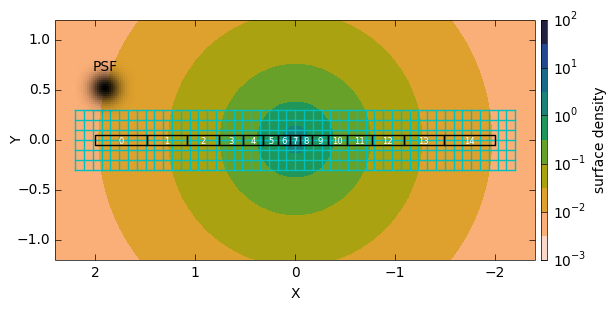

In [36]:
def show_grid_kin(ax, cax, xmin, xmax, ymin, ymax):
    # show the surface density profile
    gridx_img = numpy.linspace(xmin, xmax, int((xmax-xmin)/0.1)+1)
    gridy_img = numpy.linspace(ymin, ymax, int((ymax-ymin)/0.1)+1)

    surface_density = true_dens_stars.projectedDensity(
        numpy.column_stack([
        numpy.repeat(gridx_img, len(gridy_img)),
        numpy.tile  (gridy_img, len(gridx_img))])
    ).reshape(len(gridx_img), len(gridy_img))
    plt.colorbar(
        ax.contourf(gridx_img, gridy_img, surface_density.T,
        norm=matplotlib.colors.LogNorm(vmin=1e-3, vmax=1e2),
        cmap='earth_r', levels=numpy.logspace(-3, 2, 11), zorder=-1),
    label='surface density', cax=cax)

    # show the internal grid of the LOSVD target
    for xk in gridx_kin:
        ax.plot([xk, xk], [gridy_kin[0], gridy_kin[-1]], color='c', zorder=-1)
    for yk in gridy_kin:
        ax.plot([gridx_kin[0], gridx_kin[-1]], [yk, yk], color='c', zorder=-1)

    # show the apertures
    coll = matplotlib.collections.PatchCollection(
        [matplotlib.patches.Polygon(ap, color='k', closed=True, fill=False) for ap in apertures],
        match_original=True)
    ax.add_collection(coll)

    # show the PSF
    xpsf = numpy.linspace(-2.9*psf, 2.9*psf, 30)
    xypsf = numpy.column_stack([numpy.repeat(xpsf, len(xpsf)), numpy.tile(xpsf, len(xpsf))])
    opacity = numpy.exp(-0.5 * numpy.sum(xypsf**2, axis=1) / psf**2)
    imgpsf = numpy.column_stack([numpy.zeros((len(xypsf),3)), opacity]).reshape(len(xpsf), len(xpsf), 4)
    ax.imshow(imgpsf, extent=(1.9-3*psf, 1.9+3*psf, 0.5-3*psf, 0.5+3*psf), interpolation='nearest')
    ax.text(1.9, 0.5+3*psf, 'PSF', ha='center', va='top')

    ax.set_xlabel('X')
    ax.set_ylabel('Y', labelpad=-4)
    ax.set_xlim(xmax, xmin)  # flip the X axis!
    ax.set_ylim(ymin, ymax)
    ax.set_aspect('equal')
    
    return coll

plt.figure(figsize=(6, 3))
ax  = plt.axes([0.08, 0.15, 0.80, 0.80])
cax = plt.axes([0.89, 0.15, 0.01, 0.80])
show_grid_kin(ax, cax, -2.4, 2.4, -1.2, 1.2)
for xa in range(len(apertures)):
    ax.text(XY_aperture_centers[xa,0], XY_aperture_centers[xa,1]-0.015, str(xa),
        fontsize=6, ha='center', va='center', color='w')

#### Representing the LOSVD:  B-splines and Gauss–Hermite moments
We create the mock kinematic datacube by applying the `LOSVD` target to an N-body snapshot (mock dataset generated earlier). It is represented by B-splines in velocity in each aperture; these are not normalized probability distributions, but rather scaled so that the integral $\int \mathfrak{f}(v_Z)\;dv_Z$ is the total mass of stars contributing to this aperture (equivalently, the surface density convolved with the PSF and integrated over the area of the aperture).

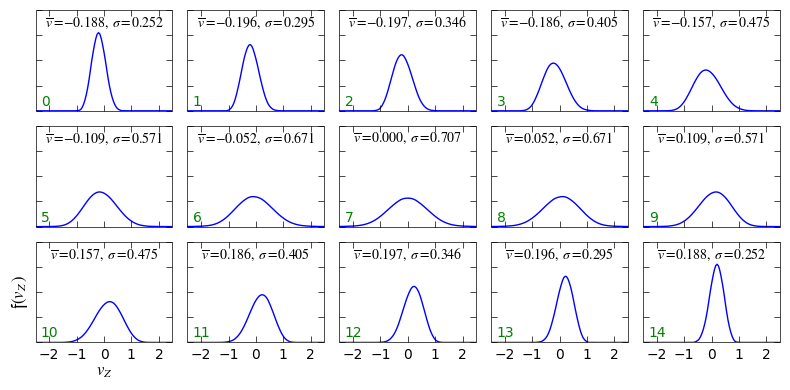

In [37]:
true_ampl_losvd = target_losvd(snapshot).reshape(len(apertures), len(gridv_kin) + degree_kin - 1)
ax = plt.subplots(3, 5, figsize=(8, 4), sharex=True, sharey=True)[1].reshape(-1)
gridv_plot = numpy.linspace(min(gridv_kin), max(gridv_kin), 101)
for ind_ap in range(len(ax)):
    if ind_ap < len(apertures):
        # interpolator for f(v_z) in this aperture
        losvd = agama.Spline(gridv_kin, ampl=true_ampl_losvd[ind_ap])
        # integrals of f(v_z) v_z^n dv_z over the velocity space for n=0,1,2
        int0  = losvd.integrate(min(gridv_kin), max(gridv_kin))
        int1  = losvd.integrate(min(gridv_kin), max(gridv_kin), n=1)
        int2  = losvd.integrate(min(gridv_kin), max(gridv_kin), n=2)
        # moments of velocity distribution: mean v and its standard deviation
        # (called "dispersion" in astronomical literature)
        meanv = int1 / int0
        sigma = (int2 / int0 - meanv**2)**0.5
        # plot the normalized distributions (divide f(v_z) by its integral over the velocity axis)
        ax[ind_ap].plot(gridv_plot, losvd(gridv_plot) / int0, color='b')
        ax[ind_ap].text(0.5, 0.95, r'$\overline{v}=%.3f,\, \sigma=%.3f$' % (meanv, sigma),
            ha='center', va='top', transform=ax[ind_ap].transAxes)
        ax[ind_ap].text(0.05, 0.05, str(ind_ap), transform=ax[ind_ap].transAxes, color='g')
    else:
        ax[ind_ap].set_axis_off()
ax[0].set_xlim(min(gridv_kin), max(gridv_kin))
ax[0].set_ylim(0, 2)
ax[0].set_xticks(numpy.linspace(-2, 2, 5))
ax[0].set_yticklabels([])
ax[10].set_xlabel('$v_Z$', fontsize=12, labelpad=0)
ax[10].set_ylabel(r'$\mathfrak{f}(v_Z)$', labelpad=0, fontsize=12)
plt.tight_layout()

B-splines are rarely used to represent observed velocity distributions, and existing applications are restricted to the case of histograms (i.e. degree=0).
The more common alternative approach for representing LOSVDs is the Gauss–Hermite expansion (see section A.2.6 in `reference.pdf`): <br>
$\displaystyle \mathfrak{f}(v) = \frac{\Xi}{\sqrt{2\pi}\,\varsigma}\;
\exp\left[-\frac{1}{2}\left(\frac{v-v_0}{\varsigma}\right)^2\right]\;
\sum_{m=0}^{M} h_m\, \mathcal H_m\left(\frac{v-v_0}{\varsigma}\right)$,<br>
where $\Xi$ is the overall amplitude, $v_0$ and $\varsigma$ are the center and the width of the base Gaussian, basis functions $\mathcal H_m(y)$ are the Hermite polynomials, defined by a recurrence relation<br>
$\mathcal H_0=1,\; \mathcal H_1=\sqrt{2}\,y,\; \mathcal H_{m+1}=\big[\sqrt{2}\,y\,\mathcal H_m - \sqrt{m}\,\mathcal H_{m-1}\big] \big/ \sqrt{m+1}$,<br>
and $h_m$ are the Gauss–Hermite coefficients. Almost always one sets $h_0$=1, $h_1$=$h_2$=0, and terms $h_{\ge 3}$ describe the deviation of the LOSVD from a pure Gaussian.<br>
Importantly, $v_0$ and $\varsigma$ are not identical to the mean velocity $\overline v$ and its dispersion (rather, standard deviation) $\sigma$: these quantities have contributions from all GH terms $h_m$ (odd $m$ for $\overline v$, even $m$ for $\sigma$).

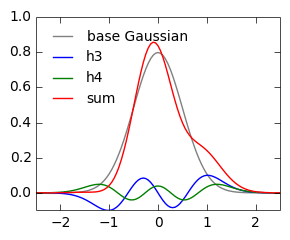

In [38]:
plt.figure(figsize=(3, 2.5))
h3 = 0.16
h4 = 0.08
plt.plot(gridv_plot, agama.ghInterp(1., 0, 0.5, [1, 0, 0        ], gridv_plot), c='gray', label='base Gaussian')
plt.plot(gridv_plot, agama.ghInterp(1., 0, 0.5, [0, 0, 0, h3    ], gridv_plot), c='b', label='h3')
plt.plot(gridv_plot, agama.ghInterp(1., 0, 0.5, [0, 0, 0,  0, h4], gridv_plot), c='g', label='h4')
plt.plot(gridv_plot, agama.ghInterp(1., 0, 0.5, [1, 0, 0, h3, h4], gridv_plot), c='r', label='sum')
plt.xlim(min(gridv_plot), max(gridv_plot))
plt.ylim(-0.1, 1)
plt.legend(loc='upper left', frameon=False, fontsize=10)
plt.tight_layout()

Like B-splines, Gauss–Hermite series form a basis set and can approximate any function $f$, given a sufficient number of terms; naturally, they are better suited for bell-shaped functions that resemble Gaussians. A B-spline basis is defined by the degree, the number of grid nodes, and their locations; once these are specified, the amplitudes (coefficients of the expansion) are computed by projecting the function $f$ onto the basis. Likewise, the GH expansion is specified by the parameters of the base Gaussian $\Xi$, $v_0$ and $\varsigma$, and any function can then be converted into the coefficients of expansion. Unlike the B-spline basis, GH basis functions are orthogonal, and each coefficient is independent from others (i.e. if one constructs two approximations of the same function with orders $M_1$ and $M_2$, their coefficients of orders $m\le \text{min}(M_1, M_2)$ coincide). 

The routine `ghMoments` constructs the GH approximation for functions represented  as B-spline interpolators, and can operate in two regimes. In the first one, the parameters of the base Gaussian are chosen to produce the best-fitting Gaussian for the given function; this implies that the lowest-order coefficients are fixed to $h_0=1,\; h_1=h_2=0$. In the second regime, one explicitly provides these parameters ($\Xi$, $v_0$ and $\varsigma$), and the resulting GH coefficients can have any values (i.e. $h_0\ne 1,\; h_1,h_2 \ne 0$ in general).

To create our mock kinematic observations, we convert the B-spline representations of LOSVDs obtained earlier into the GH coefficients. Then we assign some fiducial measurement uncertainties and add Gaussian noise to the true values of $v_0$, $\varsigma$ and higher-order GH coefficients $h_3, h_4, \dots$<br>
Importantly, the observed quantites are a mix of the parameters of the base Gaussians ($v_0$, $\varsigma$) and the GH moments $h_{m\ge 3}$; the overall amplitudes $\Xi$ are usually not available, as explained earlier. We will refer to this mix as the "GH expansion parameters", rather than "GH moments".

In [39]:
gh_order = 4
# Use ghMoments routine in the first regime, where it determines
# both the parameters of the best-fitting Gaussian and the entire GH series.
# Input matrix of B-spline amplitudes has shape  num_apertures * num_basis_coefficients,
# and the returned matrix of GH expansion has shape  num_apertures * (gh_order+4):
# the first three columns are the overall normalizations (Xi), centers (v_0) and widths (varsigma)
# of the base Gaussian in each aperture, and the remaining M+1 = gh_order+1 columns contain
# the coefficients h_0..h_M, with the first three of them being trivial (1, 0, 0).
true_gh_params= agama.ghMoments(
    degree=degree_kin,
    gridv=gridv_kin,
    matrix=true_ampl_losvd,
    ghorder=gh_order)
true_Xi = true_gh_params[:,0]
true_v0 = true_gh_params[:,1]
true_varsigma = true_gh_params[:,2]
true_gh_moments = true_gh_params[:,3:]  # h_0..h_M
true_gh_params = numpy.column_stack((true_v0, true_varsigma, true_gh_moments[:,3:]))
print('Matrix of B-spline amplitudes: %s, matrix of Gauss-Hermite expansion params: %s' %
    (true_ampl_losvd.shape, true_gh_params.shape))

# assign measurement uncertainties for GH parameters v_0, varsigma (*not* for h_1, h_2), h_3, h_4...
obs_gh_errors = numpy.column_stack([
    numpy.ones(len(apertures)) * 0.05,
    0.1 * true_varsigma,
    numpy.ones((len(apertures), gh_order-2)) * 0.02,
])

# add noise to the true values of GH parameters
numpy.random.seed(42)
obs_gh_params = true_gh_params + numpy.random.normal(size=(len(apertures), gh_order)) * obs_gh_errors

Matrix of B-spline amplitudes: (15, 27), matrix of Gauss-Hermite expansion params: (15, 4)


An advantage of using 1d slit observations is that we can easily visualize the profiles of observed quantities together with their uncertainties! for the 2d IFU observations, one has to look at color-coded maps of GH parameters, and uncertainties are rarely shown.

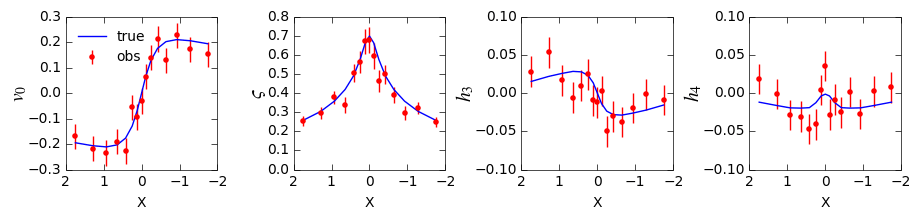

In [40]:
def show_gh_params(gh_params, label):
    ax = plt.subplots(1, gh_order, figsize=(2.25*gh_order, 2), sharex=True)[1]
    for ind_gh in range(gh_order):
        ax[ind_gh].plot(XY_aperture_centers[:,0], gh_params[:,ind_gh], color='b', label=label)
        ax[ind_gh].errorbar(XY_aperture_centers[:,0], obs_gh_params[:,ind_gh], yerr=obs_gh_errors[:,ind_gh],
            fmt='o', mew=0, ms=4, color='r', label='obs')
        ax[ind_gh].set_ylabel('$v_0$' if ind_gh==0 else (r'$\varsigma$' if ind_gh==1 else '$h_{%i}$' % (ind_gh+1)),
            labelpad=0, fontsize=14)
        ax[ind_gh].set_xlabel('X')
    ax[0].legend(loc='upper left', frameon=False, fontsize=10, numpoints=1)
    ax[0].set_xlim(max(gridx_slit), min(gridx_slit))  # again, flip the sign of X axis
    ax[0].set_xticks(numpy.linspace(-2, 2, 5))
    ax[1].set_ylim(0, 0.8)
    for a in ax[2:]: a.set_ylim(-0.1, 0.1)
    plt.tight_layout(pad=0)

show_gh_params(true_gh_params, 'true')

#### Density target

In addition to the `LOSVD` target introduced above, we also need to constrain the 3d density, which we do with the help of a `DensitySphHarm` target. Although the potential is spherically symmetric, we set the order of spherical-harmonic expansion of the target to a positive value, because orbit with different orientations contribute differently to the observational constraints. If we only fixed the spherical part of the mass profile, the solution may not have a uniform distribution of orbital planes, as required for self-consistency.

#### Creating the Schwarzschild model

The goal of our exercise is to measure the mass distribution, so both the BH mass and the total stellar mass will be free parameters (but we assume that the stellar density profile is known up to its normalization).<br>
It will be useful to split the two stages: construction of the orbit library and the solution of the optimization problem. As we shall see shortly, the second step can be performed multiple times for the same orbit library.

To facilitate the exchange of data between various routines, we collect the results of orbit integration in a simple container object named `model` with several elements: array of orbit interpolators, matrices produced by `Target` objects applied to the orbit library, and various auxiliary info – we will later visualize the distribution of orbits in the space of integrals of motion $E$, $L$, $L_z$, or rather the more useful derived quantities $r_\text{circ}(E)$, $\eta\equiv [L/L_\text{circ}(E)]^2$ and $\cos i\equiv L_z/L$. $\eta$ is a measure of orbit circularity; we use the squared quantity, since isotropic systems have a uniform distribution in $\eta$. The cosine of the orbit inclination angle $\cos i$ ranges from $+1$ for prograde orbits in the equatorial plane, through zero for polar orbits, to $-1$ for retrograde orbits. This container object will be gradually populated with other data.

In [41]:
gridr_density = numpy.logspace(-1.7, 1.3, 25)
target_density = agama.Target(type='DensitySphHarm', gridr=gridr_density, lmax=4, mmax=4)
num_orbits = 5000

def determine_orbit_properties(potential, xv):
    # compute the orbital parameters for the 6d phase-space points;
    # these will be used to visualize the distribution of orbits in the integrals space
    E  = potential.potential(xv[:,0:3]) + 0.5 * numpy.sum(xv[:,3:6]**2, axis=1)
    Lx = xv[:,1] * xv[:,5] - xv[:,2] * xv[:,4]
    Ly = xv[:,2] * xv[:,3] - xv[:,0] * xv[:,5]
    Lz = xv[:,0] * xv[:,4] - xv[:,1] * xv[:,3]
    L2 = Lx**2 + Ly**2 + Lz**2
    Rcirc = potential.Rcirc(E=E)
    Lcirc = 2*numpy.pi * Rcirc**2 / potential.Tcirc(E)
    eta   = L2 / Lcirc**2
    cosi  = Lz / L2**0.5
    return Rcirc, eta, cosi

def create_orbit_library(stellar_mass, bh_mass):
    model = type('Model', (), {})  # new empty container, will now assign its properties

    model.total_mass = stellar_mass
    model.dens_stars = pot_stars = agama.Potential(
        type='Spheroid', gamma=1, beta=5, mass=stellar_mass, scaleRadius=1)
    model.potential  = pot_stars + agama.Potential(type='Plummer', mass=bh_mass, scaleRadius=1e-6)

    model.ic = model.dens_stars.sample(num_orbits, potential=model.potential)[0]
    model.Rcirc, model.eta, model.cosi = determine_orbit_properties(model.potential, model.ic)

    model.matrix_density, model.matrix_losvd, model.orbits = agama.orbit(
        potential=model.potential,
        ic=model.ic,
        time=100*model.potential.Tcirc(model.ic),
        dtype=object,
        targets=[target_density, target_losvd])

    return model

model = create_orbit_library(stellar_mass=1.0, bh_mass=0.1)

5000 orbits complete (214.1 orbits/s)                  


When it comes to solving the optimization problem, one need some extra steps to convert the data recorded during orbit integration into the matrix $\mathcal D$ provided to the solver.

The orbit LOSVDs are stored in the 2d array `matrix_losvd` of shape `num_orbits` $\times$ `len(target_losvd)`, and the latter quantity is itself the number of apertures times the number of B-spline basis functions.
We need to compare the weighted sum of orbit LOSVDs in each aperture to the observed one, parametrized by the Gauss–Hermite expansion in our example (the procedure will be somewhat different for a histogrammed representation of the observed LOSVD). This is achieved by the same routine `ghMoments` as we used to construct the observed GH expansions in the first place, but with two important details.<br>
- The overall amplitude $\Xi$ of the LOSVD in each aperture is not provided in the kinematic dataset, so needs to be computed from the density profile. This is achieved by applying `target_losvd` to the input density profile, which returns the aperture mass (the integral $\int \mathfrak{f}(v_Z)\;dv_Z$). A subtle detail is that the aperture mass is *not* the same as $\Xi$, because for a GH expansion it contains the integrals of all even-$m$ GH basis functions multiplied by the respective coefficients of expansion $h_m$. Although we set $h_0=1$ and $h_2=0$ by convention, terms with $m=4$ and higher also contribute non-negligibly.
- In order to assemble a linear combination of GH expansion coefficients, which can be compared to the observational data, we need to use *the same* parameters of base Gaussians for all orbits (in a given aperture). Only then the weighted sum $\sum_{i=1}^{N_\text{orbits}} w_i\,h_{m,i}$ can be fitted to the observed values of $h_m$. So we use the observed values of $v_0$ and $\varsigma$ as the parameters of the base Gaussian, but how to deal with their uncertainties $\epsilon_{v_0}, \epsilon_\varsigma$? We translate them into the uncertainties on $h_1, h_2$, which in the linear approximation (valid when all $|h_m| \ll 1$) are $\epsilon_{h_1} = \epsilon_{v_0} \big / \big(\sqrt{2}\varsigma\big),\; \epsilon_{h_2} = \epsilon_\varsigma \big/ \big(\sqrt{2}\varsigma\big)$. The measured values (r.h.s. of the matrix equation) are $h_1=h_2=0,\; h_{m\ge3}$ provided in the observational dataset, and their (inverse squared) uncertainties $\epsilon_{h_{m\ge 1}}$ are used as penalties in the least-squares fitting.<br>
The $h_0$ coefficient also needs to be constrained, otherwise the solver might come up with a combination of orbit LOSVDs that has $h_0$ very different from unity, and thus the shape of the LOSVD bearing little resemblance to the observed one. However, in practice it is better to constrain the aperture mass rather than $h_0$; the relative uncertainty on it can be set at the percent level (but not exactly zero). In principle, if the model fits the 3d density profile, it should also fit the aperture masses (which are essentially the projected density integrated over the area of the aperture), but since the 3d and 2d datasets have different discretization schemes, this is not automatically guaranteed, and needs to be explicitly requested.

In [42]:
# values of GH moments h_1..h_M that are used as constraints (i.e. the rhs vector "r")
constraints_gh_moments = numpy.column_stack((
    numpy.zeros((len(apertures), 2)),  # h_1=h_2=0
    obs_gh_params[:,2:],               # h_3..h_M
)).reshape(-1)
# corresponding uncertainties on GH moments h_1..h_M
constraints_gh_moments_uncertainty = numpy.column_stack((
    obs_gh_errors[:,0:2] / obs_gh_params[:,(1,)] / 2**0.5,  # uncertainty on v_0,varsigma => h_1,h_2
    obs_gh_errors[:,2:],   # higher-order moments h_3..h_M
)).reshape(-1)
# relative uncertainty on aperture masses
aperture_mass_tolerance = 0.01

def prepare_optimization_problem(model):
    model.constraints_density = target_density(model.dens_stars)
    # for the DensitySphHarm target, only the first len(gridr)+1 values corresponding to l=0
    # need to be summed to get the total mass within the extent of the grid
    print('total mass enclosed within density grid: %g' %
        sum(model.constraints_density[:len(gridr_density)+1]))

    # construct the parameters of base Gaussians
    model.aperture_mass = target_losvd(model.dens_stars)
    # correction for the normalization coming from higher-order GH moments
    mult = 0.5**0.5
    norm = numpy.ones(len(apertures))
    for m in range(4, gh_order+1, 2):
        mult *= (1-1./m)**0.5
        norm += obs_gh_params[:,m-1] * mult
    gh_basis = numpy.column_stack((   # parameters of base Gaussians in each aperture
        model.aperture_mass / norm,   # Xi
        obs_gh_params[:, 0:2]))       # v_0, varsigma

    # convert the B-spline representations of orbit LOSVDs into GH moments h_1..h_M
    model.matrix_gh_moments = (agama.ghMoments(
        degree=degree_kin,
        gridv=gridv_kin,
        matrix=model.matrix_losvd,
        ghorder=gh_order,
        ghbasis=gh_basis,
    ).reshape(num_orbits, len(apertures),  gh_order+1)[:, :, 1:]  # remove h_0
    ).reshape(num_orbits, len(apertures) * gh_order)

    # separately from the above, compute the matrix of constraints corresponding to aperture masses.
    # The routine bsplineIntegrals computes the integrals of each B-spline basis function over
    # the velocity axis; when multiplied by the vector of amplitudes (for each orbit in each aperture),
    # the result is the integral of the corresponding orbit's LOSVD over velocity, i.e. its contribution
    # to each aperture mass.
    model.matrix_aperture_mass = (
        model.matrix_losvd.reshape(num_orbits, len(apertures), len(gridv_kin) + degree_kin - 1).
        dot(agama.bsplineIntegrals(degree_kin, gridv_kin)))

def solve_optimization_problem(model):
    model.weights = agama.solveOpt(
        matrix=[
            model.matrix_density.T,        # fraction of time each orbit spends in each cell
            numpy.ones((1, num_orbits)),   # fraction of time each orbit spends inside entire space (i.e. 100%)
            model.matrix_gh_moments.T,     # contributions of each orbit to GH moments h_1..h_m in each aperture
            model.matrix_aperture_mass.T], # contributions of each orbit to aperture masses
        rhs=[
            model.constraints_density,
            [model.total_mass],
            constraints_gh_moments,
            model.aperture_mass],
        rpenq=[
            model.constraints_density + numpy.inf,
            [numpy.inf],
            2*constraints_gh_moments_uncertainty**-2,
            2*(model.aperture_mass * aperture_mass_tolerance)**-2],
    )

def analyze_results(model):
    print('chi^2 for ' + ',  '.join(['h%i: %%.1f' % i for i in range(1,gh_order+1)]) % tuple(
        numpy.sum(((model.matrix_gh_moments.T.dot(model.weights) - constraints_gh_moments) /
                   constraints_gh_moments_uncertainty).reshape(len(apertures),-1)**2, axis=0) ))
    # compute the difference between the GH parameters of the orbit-superposition model and the observations:
    # first construct B-spline representations of LOSVDs of the weighted sum of orbits (the model)
    model.ampl_losvd = model.matrix_losvd.T.dot(model.weights).reshape(len(apertures), -1)
    # compute the aperture masses by integrating B-splines over the velocity axis, and their deviations from rhs
    result_aperture_mass = model.ampl_losvd.dot(agama.bsplineIntegrals(degree_kin, gridv_kin))
    chi2_aperture_mass = sum(((result_aperture_mass / model.aperture_mass - 1) / aperture_mass_tolerance)**2)
    # convert B-splines into GH parameters (v_0, varsigma, h_3, h_4, ...), where v_0 and varsigma
    # are now determined from the model LOSVDs, rather than fixed to those given by the observations
    model.gh_params = agama.ghMoments(
        degree=degree_kin,
        gridv=gridv_kin,
        matrix=model.ampl_losvd,
        ghorder=gh_order
    )[:, (1,2) + tuple(range(6, 6+gh_order-2))]
    # penalty for each GH parameter (v_0, varsigma, h_3, h_4,...) summed over all apertures
    model.chi2 = numpy.sum(((model.gh_params - obs_gh_params) / obs_gh_errors)**2, axis=0)
    print('chi^2 for aperture mass: %.1g' % chi2_aperture_mass +
          ',  v0: %.1f,  sigma: %.1f,  ' % (model.chi2[0], model.chi2[1]) +
          ',  '.join(['h%i: %.1f' % (i+3, model.chi2[i+2]) for i in range(gh_order-2)]) +
          ',  total: %.1f' % sum(model.chi2))

prepare_optimization_problem(model)
solve_optimization_problem(model)
analyze_results(model)

total mass enclosed within density grid: 0.993384
Using a custom optimized KKT solver
numVariables=5075, numConstraints=227, numConsIneq=5000
     pcost       dcost       gap    pres   dres
 0:  2.1283e+00  3.3172e+00  7e+03  9e+01  9e+01
 1:  4.0104e+00  4.5974e+00  7e+02  8e+00  8e+00
 2:  5.6088e+00  6.7744e+00  2e+02  2e+00  2e+00
 3:  7.5389e+00  8.4185e+00  7e+01  7e-01  7e-01
 4:  8.8473e+00  9.3353e+00  3e+01  3e-01  3e-01
 5:  9.5233e+00  9.8945e+00  2e+01  2e-01  2e-01
 6:  1.0209e+01  1.0616e+01  2e+01  1e-01  1e-01
 7:  1.0579e+01  1.1455e+01  1e+01  8e-02  8e-02
 8:  1.1069e+01  1.2257e+01  1e+01  5e-02  5e-02
 9:  1.1726e+01  1.3147e+01  8e+00  3e-02  3e-02
10:  1.2276e+01  1.3783e+01  7e+00  3e-02  3e-02
11:  1.3227e+01  1.4530e+01  5e+00  2e-02  2e-02
12:  1.3997e+01  1.4981e+01  4e+00  1e-02  1e-02
13:  1.4640e+01  1.5149e+01  4e+00  8e-03  8e-03
14:  1.5260e+01  1.5303e+01  3e+00  5e-03  5e-03
15:  1.5617e+01  1.5374e+01  2e+00  3e-03  3e-03
16:  1.5785e+01  1.5442e+0

#### Visualizing the model

Let us compare the GH parameters in our fitted model with the observed ones (recall that they have some noise).

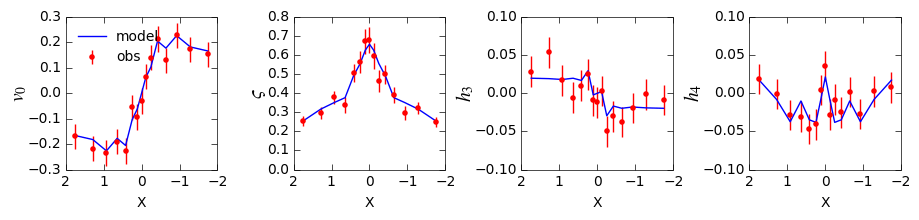

In [43]:
show_gh_params(model.gh_params, 'model')

Looks like the model fits the observed data pretty well, which is not suprising, given that it was constructed with the true values of stellar and BH mass. In fact, it even seems to be overfitting the noise in the data, and the values of $\chi^2$ are smaller than could be expected for the given number of constraints (15 apertures times 4 GH parameters in each). <br>
We can assess the "EDI score" of the model (uniformity of the weights distribution), and visualize the distribution of orbits in the space of integrals of motion.

max weight (closer to unity = better): 190
mean square weight (closer to unity = better): 68.1
entropy of weight distribution (less negative = better): -3.88
fraction of orbits contributing 90% of total mass (more = better): 95/5000


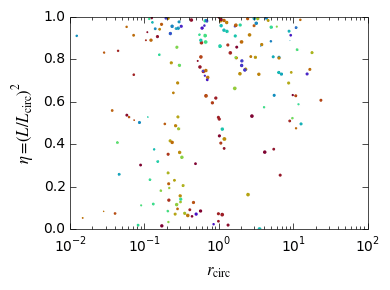

In [44]:
def show_orbit_distribution(model):
    normalized_weights = model.weights * len(model.weights) / numpy.sum(model.weights)
    # size proportional to orbit weight, nearly zero for orbits with weights much less than the mean
    marker_size = numpy.log(1 + normalized_weights*10)
    plt.figure(figsize=(4, 3))
    plt.scatter(model.Rcirc, model.eta, c=model.cosi, s=marker_size, lw=0, cmap='mist', vmin=-1, vmax=1)
    plt.xscale('log')
    plt.ylim(0, 1)
    plt.ylabel(r'$\eta = (L/L_{\rm{circ}})^2$', fontsize=12)
    plt.xlim(1e-2, 1e2)
    plt.xlabel(r'$r_{\rm circ}$', fontsize=12)
    plt.tight_layout()

analyze_weights(model.weights)
show_orbit_distribution(model)

No, this is not a particularly smooth model! the number of orbits with significant weights is very small; this not only wastes computational resources, but also exemplifies overfitting.

Let us amend the situation by adding the regularization penalty to the solution, with an adjustable coefficient `regul`. We define this parameter to be dimensionless, invariant w.r.t. change of the total mass or the number of orbits, and producing penalty (contribution to $\chi^2$) of order unity for `regul=1.0`.

Using a custom optimized KKT solver
numVariables=5075, numConstraints=227, numConsIneq=5000
     pcost       dcost       gap    pres   dres
 0:  1.7946e+01  1.6941e+01  5e+03  7e+01  7e+01
 1:  1.7946e+01  1.6943e+01  7e+01  9e-01  9e-01
 2:  1.7946e+01  1.7031e+01  2e+01  2e-01  2e-01
 3:  1.8274e+01  1.7352e+01  2e+01  2e-01  2e-01
 4:  1.8443e+01  1.7701e+01  1e+01  1e-01  1e-01
 5:  1.8758e+01  1.8356e+01  1e+01  7e-02  7e-02
 6:  1.9112e+01  1.8993e+01  9e+00  5e-02  5e-02
 7:  1.9665e+01  1.9676e+01  7e+00  3e-02  3e-02
 8:  2.0294e+01  2.0314e+01  5e+00  2e-02  2e-02
 9:  2.0989e+01  2.0903e+01  4e+00  1e-02  1e-02
10:  2.1529e+01  2.1259e+01  3e+00  7e-03  7e-03
11:  2.1930e+01  2.1545e+01  2e+00  4e-03  4e-03
12:  2.2232e+01  2.1778e+01  1e+00  2e-03  2e-03
13:  2.2441e+01  2.2233e+01  2e-01  8e-06  8e-06
14:  2.2385e+01  2.2343e+01  4e-02  1e-06  1e-06
15:  2.2370e+01  2.2366e+01  4e-03  7e-08  7e-08
16:  2.2369e+01  2.2368e+01  2e-04  2e-09  2e-09
17:  2.2369e+01  2.2369e+01

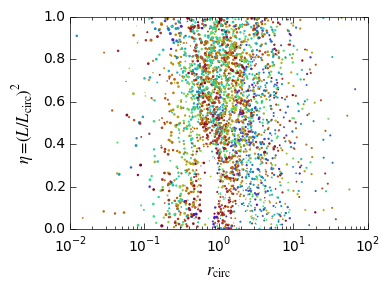

In [45]:
def solve_optimization_problem(model, regul=0.0):
    model.weights = agama.solveOpt(
        matrix=[
            model.matrix_density.T, 
            numpy.ones((1, num_orbits)),
            model.matrix_gh_moments.T,
            model.matrix_aperture_mass.T],
        rhs=[
            model.constraints_density,
            [model.total_mass],
            constraints_gh_moments,
            model.aperture_mass],
        rpenq=[
            model.constraints_density + numpy.inf,
            [numpy.inf],
            2*constraints_gh_moments_uncertainty**-2,
            2*(model.aperture_mass * aperture_mass_tolerance)**-2],
        # adding regularization with strength controlled by the "regul" parameter, values of order unity are "mild"
        xpenq=2 * numpy.ones(num_orbits) * num_orbits / model.total_mass**2 * regul,
    )

solve_optimization_problem(model, regul=1.0)
analyze_results(model)
analyze_weights(model.weights)
show_orbit_distribution(model)

This is a much better result, and the $\chi^2$ values increased only mildly for our choice of regularization parameter (1.0). The optimal choice is situation-dependent, and unfortunately there is no universally accepted and well-motivated recipe or prescription (although [Lipka&Thomas 2021](http://adsabs.harvard.edu/abs/2021MNRAS.504.4599L) provide a good insight and an objective method for calibrating regularization).

Let us also examine the actual LOSVDs of the model, not just their GH approximations that were fitted to the observational constraints.

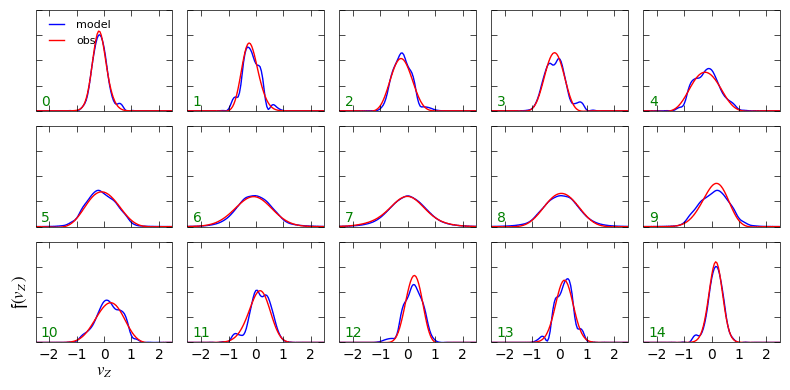

In [46]:
def show_losvds(model):
    ax = plt.subplots(3, 5, figsize=(8, 4), sharex=True, sharey=True)[1].reshape(-1)
    for ind_ap in range(len(apertures)):
        # model LOSVDs represented by B-splines, normalized to have unit integral
        losvd = agama.Spline(gridv_kin, ampl=model.ampl_losvd[ind_ap])
        int0  = losvd.integrate(min(gridv_kin), max(gridv_kin))
        ax[ind_ap].plot(gridv_plot, losvd(gridv_plot) / int0, color='b', label='model')
        # observed LOSVDs (with noise) represented by GH expansions, normalized to have Xi=1
        # (not quite the same as normalizing to have unit integral, but will do the job)
        ax[ind_ap].plot(gridv_plot,
            agama.ghInterp(1.0, obs_gh_params[ind_ap, 0], obs_gh_params[ind_ap, 1],
                numpy.hstack([1, 0, 0, obs_gh_params[ind_ap, 2:]]), gridv_plot),
            color='r', label='obs')
        ax[ind_ap].text(0.05, 0.05, str(ind_ap), transform=ax[ind_ap].transAxes, color='g')
    ax[0].set_xlim(min(gridv_kin), max(gridv_kin))
    ax[0].set_ylim(0, 2)
    ax[0].set_xticks(numpy.linspace(-2, 2, 5))
    ax[0].set_yticklabels([])
    ax[10].set_xlabel('$v_Z$', fontsize=12, labelpad=0)
    ax[10].set_ylabel(r'$\mathfrak{f}(v_Z)$', labelpad=0, fontsize=12)
    ax[0].legend(loc='upper left', frameon=False, fontsize=8)
    plt.tight_layout()

show_losvds(model)

The model LOSVDs are quite a bit noisier than the observed ones, but that's because they are represented by B-splines with two dozen coefficients, while the observed ones are just low-order GH expansions with four coefficients. The optimization solver was requested to fit these GH moments, which it did, but nothing was done to prevent higher-frequency variations of the LOSVDs (although regularization did help a bit). It may be advisable to add "fake" constraints on higher-order GH moments to be close to zero (with some generous but not too large uncertainty, say 0.05), even if these constraints are not available in observational data; this helps to further regularize the solution (see [Liepold+2020](http://adsabs.harvard.edu/abs/2020ApJ...891....4L) for a discussion).

#### Exploring the potential parameters

Building one model is not quite the end of the story, of course. We now need to systematically explore the parameter space for the potential (namely, stellar and BH masses; everything else is assumed to be known). Each new choice would require the construction of a new model (orbit library & weights), but there is a dimensional analysis trick that saves significant computational effort.

We recall that in stellar dynamics, the mass $M$, characteristic size $r$ and characteristic velocity $\sigma$ of a stellar system are related as $G\,M / r \propto \sigma^2$. So if we rescale the mass by some dimensionless factor $\Upsilon$, keep spatial scale the same, and rescale the velocity by $\sqrt{\Upsilon}$, this would also describe a structurally identical system in equilibrium, just with a different mass and proportionally scaled velocity. This allows one to use the same orbit library, but rescale just the velocity axis in LOSVDs before fitting the model to observations.

In terms of the B-spline representations of the LOSVDs of orbits in the model, we need to multiply the velocity grid by $\sqrt{\Upsilon}$ and the amplitudes of B-splines by $1/\sqrt{\Upsilon}$, then convert them to GH moments and proceed as before.

Using a custom optimized KKT solver
numVariables=5075, numConstraints=227, numConsIneq=5000
     pcost       dcost       gap    pres   dres
 0:  2.7924e+01  2.6919e+01  5e+03  7e+01  7e+01
 1:  2.7924e+01  2.6922e+01  7e+01  1e+00  1e+00
 2:  2.7925e+01  2.7059e+01  2e+01  3e-01  3e-01
 3:  2.8239e+01  2.7251e+01  2e+01  2e-01  2e-01
 4:  2.8285e+01  2.7846e+01  2e+01  2e-01  2e-01
 5:  2.8604e+01  2.9033e+01  2e+01  1e-01  1e-01
 6:  2.9250e+01  3.0812e+01  1e+01  8e-02  8e-02
 7:  3.0050e+01  3.2507e+01  1e+01  6e-02  6e-02
 8:  3.0836e+01  3.4008e+01  1e+01  5e-02  5e-02
 9:  3.2464e+01  3.6407e+01  1e+01  3e-02  3e-02
10:  3.4352e+01  3.8737e+01  8e+00  2e-02  2e-02
11:  3.6144e+01  4.0401e+01  8e+00  2e-02  2e-02
12:  3.7648e+01  4.1564e+01  7e+00  1e-02  1e-02
13:  3.8952e+01  4.2381e+01  7e+00  9e-03  9e-03
14:  4.0501e+01  4.3135e+01  6e+00  7e-03  7e-03
15:  4.1933e+01  4.3651e+01  5e+00  5e-03  5e-03
16:  4.3628e+01  4.4166e+01  3e+00  2e-03  2e-03
17:  4.4625e+01  4.4591e+01

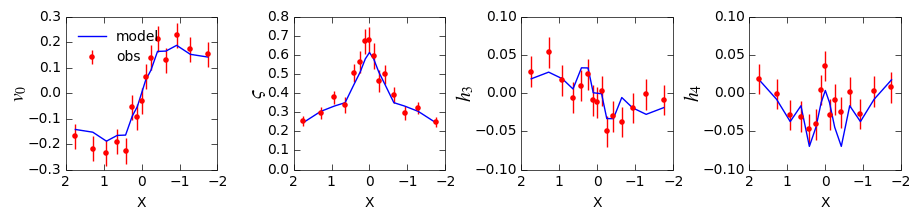

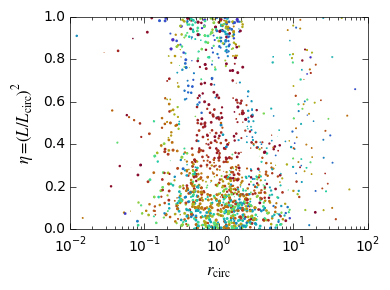

In [47]:
def prepare_optimization_problem(model, Upsilon=1.0):
    model.Upsilon = Upsilon
    model.constraints_density = target_density(model.dens_stars)

    # construct the parameters of base Gaussians: this step is the same as before, not adjusted for Upsilon
    model.aperture_mass = target_losvd(model.dens_stars)
    # correction for the normalization coming from higher-order GH moments
    mult = 0.5**0.5
    norm = numpy.ones(len(apertures))
    for m in range(4, gh_order+1, 2):
        mult *= (1-1./m)**0.5
        norm += obs_gh_params[:,m-1] * mult
    gh_basis = numpy.column_stack((   # parameters of base Gaussians in each aperture
        model.aperture_mass / norm,   # Xi
        obs_gh_params[:, 0:2]))       # v_0, varsigma

    # convert the B-spline representations of orbit LOSVDs into GH moments h_0..h_M:
    # in this step, we rescale the velocity grid and the B-spline amplitudes by sqrt{Upsilon}
    model.matrix_gh_moments = (agama.ghMoments(
        degree=degree_kin,
        gridv=gridv_kin * model.Upsilon**0.5,
        matrix=model.matrix_losvd * model.Upsilon**-0.5,
        ghorder=gh_order,
        ghbasis=gh_basis,
    ).reshape(num_orbits, len(apertures),  gh_order+1)[:, :, 1:]  # remove h_0
    ).reshape(num_orbits, len(apertures) * gh_order)

    # compute the contributions of each orbit to aperture masses; independent of Upsilon
    model.matrix_aperture_mass = (
        model.matrix_losvd.reshape(num_orbits, len(apertures), len(gridv_kin) + degree_kin - 1).
        dot(agama.bsplineIntegrals(degree_kin, gridv_kin)))

def analyze_results(model):
    # compute the difference between the GH parameters of the orbit-superposition model and the observations:
    # first construct B-spline representations of LOSVDs of the weighted sum of orbits (the model)
    model.ampl_losvd = model.matrix_losvd.T.dot(model.weights).reshape(len(apertures), -1)
    # compute the aperture masses by integrating B-splines over the velocity axis, and their deviations from rhs
    result_aperture_mass = model.ampl_losvd.dot(agama.bsplineIntegrals(degree_kin, gridv_kin))
    chi2_aperture_mass = sum(((result_aperture_mass / model.aperture_mass - 1) / aperture_mass_tolerance)**2)
    # convert B-splines into GH parameters (v_0, varsigma, h_3, h_4, ...), where v_0 and varsigma
    # are now determined from the model LOSVDs, rather than fixed to those given by the observations;
    # again we rescale the velocity grid and the B-spline amplitudes of the overall orbit superposition
    model.gh_params = agama.ghMoments(
        degree=degree_kin,
        gridv=gridv_kin * model.Upsilon**0.5,
        matrix=model.ampl_losvd * model.Upsilon**-0.5,
        ghorder=gh_order
    )[:, (1,2) + tuple(range(6, 6+gh_order-2))]
    # penalty for each GH parameter (v_0, varsigma, h_3, h_4,...) summed over all apertures
    model.chi2 = numpy.sum(((model.gh_params - obs_gh_params) / obs_gh_errors)**2, axis=0)
    print('chi^2 for aperture mass: %.1g' % chi2_aperture_mass +
          ',  v0: %.1f,  sigma: %.1f,  ' % (model.chi2[0], model.chi2[1]) +
          ',  '.join(['h%i: %.1f' % (i+3, model.chi2[i+2]) for i in range(gh_order-2)]) +
          ',  total: %.1f' % sum(model.chi2))

prepare_optimization_problem(model, Upsilon=0.6)
solve_optimization_problem(model, regul=1.0)
analyze_results(model)
analyze_weights(model.weights)
show_gh_params(model.gh_params, 'model')
show_orbit_distribution(model)

Obviously, setting a quite different $\Upsilon$ from the true value (0.6 vs. 1) deteriorates the fit quality (particularly in $\varsigma$ and even-order GH moments), so this parameter can be constrained by kinematics. Note that the orbit distribution is shifted towards more radial (lower values of orbit circularity $\eta$).<br>
We now run the solver for a grid of $\Upsilon$ values and show the resulting $\chi^2$ profile.

Upsilon=0.50 => chi2=107.3
Upsilon=0.54 => chi2=77.3
Upsilon=0.57 => chi2=56.2
Upsilon=0.62 => chi2=42.6
Upsilon=0.66 => chi2=35.4
Upsilon=0.71 => chi2=32.0
Upsilon=0.76 => chi2=30.6
Upsilon=0.81 => chi2=30.0
Upsilon=0.87 => chi2=29.6
Upsilon=0.93 => chi2=29.3
Upsilon=1.00 => chi2=29.2
Upsilon=1.07 => chi2=29.5
Upsilon=1.15 => chi2=30.1
Upsilon=1.23 => chi2=31.4
Upsilon=1.32 => chi2=33.8
Upsilon=1.41 => chi2=37.8
Upsilon=1.52 => chi2=43.9
Upsilon=1.62 => chi2=52.8


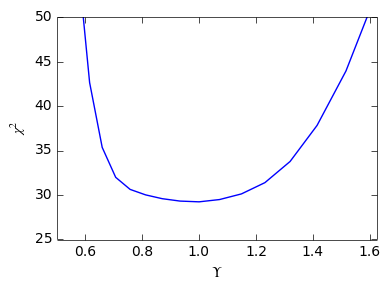

In [48]:
%%capture --no-stderr --no-display
# the above magic command hides the copious output from the optimization solver
import sys
grid_Upsilon = 2**numpy.linspace(-1, 0.7, 18)
grid_chi2 = []

for Upsilon in grid_Upsilon:
    prepare_optimization_problem(model, Upsilon=Upsilon)
    solve_optimization_problem(model, regul=1.0)
    analyze_results(model)
    grid_chi2.append(sum(model.chi2))
    sys.stderr.write('Upsilon=%.2f => chi2=%.1f\n' % (Upsilon, sum(model.chi2)))

plt.figure(figsize=(4, 3))
plt.plot(grid_Upsilon, grid_chi2)
plt.xlim(min(grid_Upsilon), max(grid_Upsilon))
plt.ylim(25, 50)
plt.xlabel(r'$\Upsilon$')
plt.ylabel(r'$\chi^2$')
plt.tight_layout()

The $\chi^2$ curve indeed has a minimum around the true value of $\Upsilon=1$, as expected.

We are now prepared to explore a 2d grid of models in the parameter space of BH mass and $\Upsilon$.<br>
For each choice of BH mass, a new orbit library needs to be constructed (this takes some time), and then the solution for orbit weights and the associated $\chi^2$ value is obtained for several choices of $\Upsilon$ (this is fairly quick in our case). For now, we consider a very small grid – just three different values of BH mass.

In [49]:
%%capture --no-stderr
grid_bh_mass = numpy.array([0.01, 0.1, 0.25])
models = []
grid_chi2 = numpy.zeros((len(grid_bh_mass), len(grid_Upsilon)))
for ind_bh, bh_mass in enumerate(grid_bh_mass):
    models.append(create_orbit_library(stellar_mass=1.0, bh_mass=bh_mass))
    for ind_Ups, Upsilon in enumerate(grid_Upsilon):
        prepare_optimization_problem(models[-1], Upsilon=Upsilon)
        solve_optimization_problem(models[-1], regul=1.0)
        analyze_results(models[-1])
        grid_chi2[ind_bh, ind_Ups] = sum(models[-1].chi2)

5000 orbits complete (233.8 orbits/s)                  
5000 orbits complete (208.2 orbits/s)                  
5000 orbits complete (184.5 orbits/s)                  


When plotting the resulting $\chi^2$ values in the parameter space of BH mass and $\Upsilon$, we need to keep in mind that our velocity rescaling trick effectively modifies not just the stellar mass-to-light ratio, but the mass scale of all potential components. So the nominal value of BH mass $\hat M_\text{BH}$ used in constructing the orbit library needs to be multiplied by $\Upsilon$ of each solution. In effect, the grid of explored models is not rectangular, but "tilted" – each series of models with the same orbit library, but different $\Upsilon$, lies along a diagonal line in the space of real $M_\text{BH}$ vs. $\Upsilon$ that intersects the origin.<br>
To display the contours of $\chi^2$ in the space of real $M_\text{BH} \equiv \Upsilon \hat M_\text{BH}$, we interpolate the values from our grid of models onto an auxiliary rectangular grid.

The difference between the $\chi^2$ value of the given model from the minimum $\chi^2$ of the overall best-fit model is used to determine the confidence intervals on model parameters. The levels of significance depend on the number of free parameters in the model (two in our case), and not on the number of data points (kinematic constraints).<br>
In the plot below, the confidence intervals corresponding to 1-sigma, 2-sigma, ... (i.e., 68%, 95%, etc.) for a two-parameter model are shown by color contours, while the grid of explored models is shown by dots, with the true value marked by a cross.

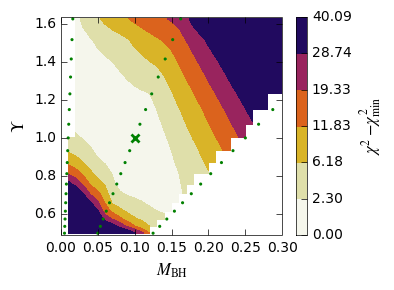

In [50]:
fine_grid_bh_mass, fine_grid_Upsilon = numpy.meshgrid(numpy.linspace(0.0, 0.3, 31), grid_Upsilon)
orig_grid_bh_mass, orig_grid_Upsilon = numpy.meshgrid(grid_bh_mass, grid_Upsilon)
bh_mass_values = (orig_grid_bh_mass * orig_grid_Upsilon).reshape(-1)
Upsilon_values = orig_grid_Upsilon.reshape(-1)
delta_chi2_values = grid_chi2.T.reshape(-1) - numpy.min(grid_chi2)

import scipy.interpolate
fac = 5.0  # scaling factor for the x axis to make its spacing similar to the y axis; improves interpolation
result = scipy.interpolate.griddata(
    (bh_mass_values * fac, Upsilon_values),
    delta_chi2_values,
    (fine_grid_bh_mass * fac, fine_grid_Upsilon),
    method='linear')

# values of delta chi^2 corresponding to 1-sigma, 2-sigma, ... confidence intervals for two model parameters
cntr = numpy.array([0, 2.30, 6.18, 11.83, 19.33, 28.74, 40.09])
result = numpy.minimum(result, cntr[-1])
plt.figure(figsize=(4,3))
plt.colorbar(
    plt.contourf(fine_grid_bh_mass, fine_grid_Upsilon, result, levels=cntr, cmap='hell_r', vmin=0, vmax=40)
).set_label(r'$\chi^2 - \chi^2_{\rm min}$', fontsize=12)
# show the locations of all models across the parameter space
plt.scatter(bh_mass_values, Upsilon_values, c='g', s=5, lw=0)
plt.xlabel(r'$M_{\rm BH}$', fontsize=12)
plt.ylabel(r'$\Upsilon$', fontsize=12)
plt.plot(true_bh_mass, 1.0, 'gx', mew=2)

plt.xlim(0, 0.3)
plt.ylim(min(grid_Upsilon)-0.01, max(grid_Upsilon)+0.01)
plt.tight_layout()

The result is somewhat disappointing: all three series of models with different $\hat M_\text{BH}$ achieved the same fit quality, but for different values of $\Upsilon$. Obviously, a lower $M_\text{BH}$ requires a higher stellar mass to reproduce the kinematics, that's why the contours of lowest $\chi^2$ are usually elongated diagonally from top left to bottom right in this space. We can plot the orbit distributions of two models with equally good fits, but higher or lower $M_\text{BH}$ than the true value, and they are clearly able to satisfy the constraints by redistributing the orbits in the $\eta$ space differently.

Using a custom optimized KKT solver
numVariables=5075, numConstraints=227, numConsIneq=5000
     pcost       dcost       gap    pres   dres
 0:  1.9010e+01  1.8005e+01  5e+03  7e+01  7e+01
 1:  1.9010e+01  1.8007e+01  7e+01  1e+00  1e+00
 2:  1.9010e+01  1.8089e+01  2e+01  3e-01  3e-01
 3:  1.9307e+01  1.8203e+01  2e+01  2e-01  2e-01
 4:  1.9354e+01  1.8390e+01  1e+01  1e-01  1e-01
 5:  1.9517e+01  1.8986e+01  1e+01  7e-02  7e-02
 6:  1.9860e+01  1.9792e+01  8e+00  5e-02  5e-02
 7:  2.0614e+01  2.0803e+01  6e+00  3e-02  3e-02
 8:  2.1329e+01  2.1543e+01  5e+00  2e-02  2e-02
 9:  2.1962e+01  2.2064e+01  4e+00  1e-02  1e-02
10:  2.2603e+01  2.2503e+01  2e+00  6e-03  6e-03
11:  2.3024e+01  2.2856e+01  1e+00  3e-03  3e-03
12:  2.3346e+01  2.3158e+01  5e-01  8e-04  8e-04
13:  2.3436e+01  2.3323e+01  2e-01  1e-04  1e-04
14:  2.3419e+01  2.3398e+01  3e-02  2e-05  2e-05
15:  2.3414e+01  2.3412e+01  1e-03  6e-07  6e-07
16:  2.3413e+01  2.3413e+01  5e-05  1e-08  1e-08
17:  2.3413e+01  2.3413e+01

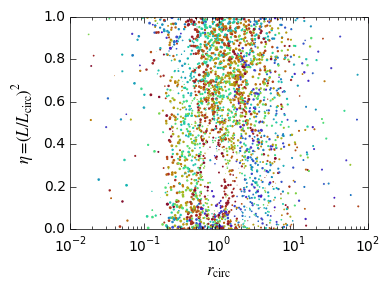

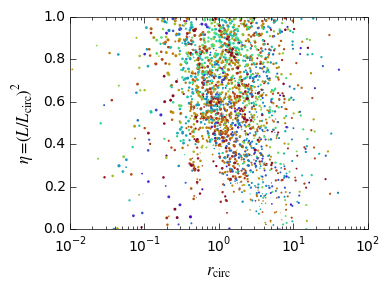

In [51]:
# model with nearly-zero BH mass but higher Upsilon
prepare_optimization_problem(models[0], Upsilon=1.5)
solve_optimization_problem(models[0], regul=1.0)
analyze_results(models[0])
show_orbit_distribution(models[0])
# model with a higher BH mass but lower Upsilon
prepare_optimization_problem(models[2], Upsilon=0.7)
solve_optimization_problem(models[2], regul=1.0)
analyze_results(models[2])
show_orbit_distribution(models[2])

#### Further steps

The above degeneracy between $M_\text{BH}$ and $\Upsilon$ is in large part caused by the limited footprint of our kinematic data. After all, long-slit spectroscopy is mostly a thing of the past, and modern IFU observations provide 2d kinematic maps. Let us create a new dataset covering an entire rectangle, rather than just a line, and also extending to larger distances and having a larger number of GH moments.

The updated example illustrates a couple of other features.<br>
First, the apertures need not be rectangular, but can have any shape – in this example, we make them circular and different in size, accounting for the fact that we generally need higher resolution in the central regions but can progressively coarse-grain kinematic maps further out, where the surface brightness is lower. In practice, this would be achieved by Voronoi-binning a rectangular grid of pixels from an IFU before running the spectral reduction pipeline.<br>
Sometimes one has two kinematic datasets coming from different instruments: the central region taken with an AO-assisted IFU, and another non-AO instrument with a larger PSF covers a larger field of view. In this case one would need to set up two `LOSVD` targets, since the PSF convolution is pre-computed at construction of the target, and they would likely need different spatial grids anyway. This extension is trivial and is not shown in the example below.

Second, the $XY$ coordinate system of the kinematic datacube may not be aligned with the major axis of the galaxy (or the line of nodes in a more general non-axisymmetric geometry). The rotation angle $\gamma_\text{kin}$ of each dataset can be provided to the constructor of the `LOSVD` target; the illustration in Appendix A.8 of `reference.pdf` explains how to specify this angle. In the example below, we set it to 45$^\circ$; the $x$ axis of the intrinsic coordinate system of the model, which lies along the line of nodes, points towards lower left and is rotated CCW by angle $\gamma_\text{kin}$ from the direction of the $X$ axis (which points leftwards).

A third feature is that the kinematic map does not need to cover the entire galaxy due to symmetry properties. For an axisymmetric system in which the $X$ axis is aligned with the line of nodes, the four quadrants (positive or negative signs of either $X$ or $Y$) all provide the same constraints on the model, since the orbital contributions to the kinematic datacube are symmetrized in both $X$ and $Y$ in this case (with a sign flip in velocity when changing $X \to -X$). If the observational data are provided in more than one quadrant, the model will effectively strike the middle ground between the measurements, so it is not necessary to symmetrize the observed maps beforehand. However, if there is a possibility to set the apertures symmetrically and perform the spectroscopic fits while combining the signal from opposite apertures, this is the preferred solution, since it increases the signal-to-noise ratio. In this case one should provide only one half (or one quarter) of the entire symmetrized datacube, since the LOSVDs in symmetrically opposite apertures will be identical by construction (up to a sign flip in velocity), so are not independent measurements.<br>
When the $X$ axis does not coincide with the line of nodes, the model still performs fourfold symmetrization in the image plane, but this no longer corresponds to a simple sign flip in either $X$ and/or $Y$. Nevertheless, all model maps are still pointwise-symmetric (invariant w.r.t. simultaneously flipping the signs of $X$, $Y$ and $v_Z$), even in the case of triaxial barred systems, so in principle one needs to provide only half of the $XY$ plane (if the data from the other half were already fitted symmetrically). In the example below, we provide only one quadrant of space, but it contains full information about the other three quadrants symmetrically flipped about the line of nodes or the orthogonal line to it. One can see that the apertures closest to the line of nodes (kinematic major axis in our case) have maximum amplitude of line-of-sight velocity $v_Z$, which represents the rotation velocity; in this quadrant, positive $v_\phi$ corresponds to positive $v_Z$.

A final detail worth keeping in mind is that the velocity grid provided to the `LOSVD` target represents the velocities of the model *before* multiplying them by $\sqrt{\Upsilon}$ when comparing to the observations. This needs to be accounted for when choosing the grid parameters according to the guidelines presented earlier (i.e., that the grid spacing should be smaller than the lowest value of velocity dispersion in the dataset, and the extent of the grid should be at least 3$\times$ larger than the highest value of velocity dispersion).
So if the expected value of $\Upsilon$ is significantly different from 1, the original `gridv` should be multiplied by $\Upsilon^{-1/2}$ (e.g. should be twice more compact when $\Upsilon\simeq 4$). Since the actual best-fit value of $\Upsilon$ may not be known before running the model, one may need to repeat the fit with a better-tuned velocity grid (or make it comfortably larger to begin with, although this increases computational cost, and excessively fine grid makes models more prone to overfitting). Already from the above runs it was clear that the best-fit $\Upsilon$ varies by a factor of two in the range of plausible $M_\text{BH}$ values.

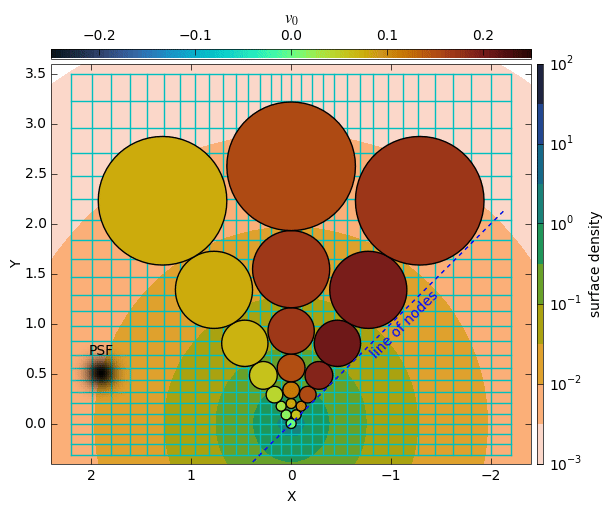

In [52]:
def make_circular_aperture(x, y, r, n_side=60):
    ang = numpy.linspace(0, 2*numpy.pi, n_side+1)[::-1]
    return numpy.column_stack((x + r * numpy.cos(ang), y + r * numpy.sin(ang)))

sin60 = 0.75**0.5
r_0 = 0.05
apertures = [
    make_circular_aperture(0, 0, r_0),
    make_circular_aperture(-r_0, 2 * sin60 * r_0, r_0),
    make_circular_aperture(+r_0, 2 * sin60 * r_0, r_0) ]
for k in range(6):
    r_k = r_0 * (5./3)**k
    d_k = r_k * 4
    apertures.extend([
        make_circular_aperture(-0.5 * d_k, sin60 * d_k, r_k),
        make_circular_aperture( 0.0,               d_k, r_k),
        make_circular_aperture(+0.5 * d_k, sin60 * d_k, r_k) ])

gridx_kin = agama.symmetricGrid(31, 0.1, 2.2)
gridy_kin = agama.symmetricGrid(41, 0.1, 3.5)[17:]
gamma_kin = numpy.pi/4
target_losvd = agama.Target(
    type='LOSVD',
    apertures=apertures,
    gridx=gridx_kin,
    gridy=gridy_kin,
    gridv=gridv_kin,
    degree=degree_kin,
    psf=psf,
    beta=beta_incl,
    gamma=gamma_kin,
    symmetry='a')

true_ampl_losvd = target_losvd(snapshot).reshape(len(apertures), len(gridv_kin) + degree_kin - 1)
gh_order = 6   # increase GH order w.r.t. previous example
true_gh_params= agama.ghMoments(degree=degree_kin, gridv=gridv_kin, matrix=true_ampl_losvd, ghorder=gh_order)
true_Xi = true_gh_params[:,0]
true_v0 = true_gh_params[:,1]
true_varsigma = true_gh_params[:,2]
true_gh_moments = true_gh_params[:,3:]  # h_0..h_M
true_gh_params = numpy.column_stack((true_v0, true_varsigma, true_gh_moments[:,3:]))
obs_gh_errors = numpy.column_stack([
    numpy.ones(len(apertures)) * 0.05,
    0.1 * true_varsigma,
    numpy.ones((len(apertures), gh_order-2)) * 0.02,
])
numpy.random.seed(42)
obs_gh_params = true_gh_params + numpy.random.normal(size=(len(apertures), gh_order)) * obs_gh_errors
constraints_gh_moments = numpy.column_stack((
    numpy.zeros((len(apertures), 2)),  # h_1=h_2=0
    obs_gh_params[:,2:],               # h_3..h_M
)).reshape(-1)
constraints_gh_moments_uncertainty = numpy.column_stack((
    obs_gh_errors[:,0:2] / obs_gh_params[:,(1,)] / 2**0.5,  # uncertainty on v_0,varsigma => h_1,h_2
    obs_gh_errors[:,2:],   # higher-order moments h_3..h_M
)).reshape(-1)

plt.figure(figsize=(6, 5))
ax  = plt.axes([0.08, 0.08, 0.80, 0.80])
cax = plt.axes([0.89, 0.08, 0.01, 0.80])
vax = plt.axes([0.08, 0.89, 0.80, 0.02])
coll = show_grid_kin(ax, cax, -2.4, 2.4, -0.4, 3.6)
# color the apertures by the central velocity v_0 of GH expansion
# (which is close to but not identical to the mean line-of-sight velocity \overline{v_Z})
coll.set_array(true_v0)
coll.set_cmap('breeze')
coll.set_clim(-0.25, 0.25)
vax.imshow(numpy.linspace(0, 1, 100).reshape(1,-1), extent=tuple(coll.get_clim())+(0, 1),
    aspect='auto', interpolation='nearest', cmap='breeze', vmin=0, vmax=1)
vax.set_xlim(coll.get_clim())
vax.set_ylim(0, 1)
vax.xaxis.tick_top()
vax.set_yticks([])
vax.set_xlabel('$v_0$', labelpad=-35, fontsize=12)
ax.set_ylabel('Y', labelpad=1)
# show the line of nodes, i.e. the projection of the intrinsic x axis onto the image plane
ax.plot(
    [-3*numpy.cos(-gamma_kin), 3*numpy.cos(-gamma_kin)],
    [-3*numpy.sin(-gamma_kin), 3*numpy.sin(-gamma_kin)],
    c='b', dashes=[3,3])
ax.text(
    -1.5*numpy.cos(-gamma_kin)+0.1*numpy.sin(-gamma_kin),
    -1.5*numpy.sin(-gamma_kin)-0.1*numpy.cos(-gamma_kin),
    'line of nodes', rotation=180/numpy.pi * gamma_kin, color='b', ha='center', va='center')
None

#### The Forstand layer

We are now ready to repeat the modelling with the updated kinematic maps.

However, instead of running the above steps, we can use the higher-level interface provided by the `agama.schwarzlib` submodule (which is roughly synonymous with the `Forstand` code). It encompasses largely the same tasks as we have implemented manually in this tutorial, but wraps them into a couple of auxiliary classes and routines:

- Instead of dealing with `Target***`s directly, one uses the corresponding `schwarzlib.***Dataset` classes (Density or several variants of kinematics, corresponding to representing observed LOSVDs in terms of GH moments or B-splines directly). These take care of the conversions between internal model representation of LOSVDs in terms of B-splines and the observationally provided constraints, including the $\Upsilon$-rescaling of the velocity axis.
- The `runModel` routine constructs the orbit library and performs scanning through the $\Upsilon$ axis automatically, finding the location of the minimum of $\chi^2$ and bracketing it from both ends by a sufficiently large offset $\Delta\chi^2$. This routine needs to be run for each choice of potential (i.e. whenever the BH mass and any other parameter except $\Upsilon$ changes). It stores the results (orbit properties, weights for all explored values of $\Upsilon$ and corresponding $\chi^2$ values) in a `numpy` zip archive, so that they can be retrieved for plotting later. It also writes the summary of model properties into a text file (one line per each model with different $\Upsilon$).
- The `runPlot` routine reads the above files and displays an interactive plot, in which one can navigate through the parameter space, pick up different models, compare the models with observations at the level of GH moments or LOSVDs in individual apertures, etc.

The few dozen of lines below encompass all steps necessary to run and display a grid of models (omitting the preparation of mock data performed earlier). This code snippet is written into a separate Python script that can be run from the terminal, and is also executed when running the cell in this notebook (this takes a few minutes); the resulting plot is interactive only when run from the terminal.

5000 orbits complete (158.3 orbits/s)                  
5000 orbits complete (146 orbits/s)                    
5000 orbits complete (139.4 orbits/s)                  
5000 orbits complete (128.4 orbits/s)                  
5000 orbits complete (116.8 orbits/s)                  
5000 orbits complete (110.8 orbits/s)                  
5000 orbits complete (105.7 orbits/s)                  


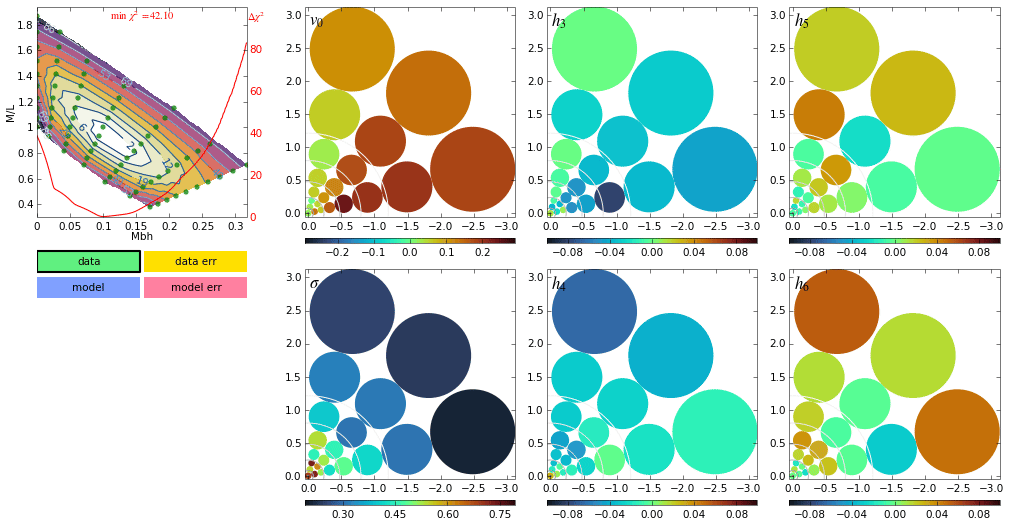

In [53]:
%%capture --no-stderr --no-display
import os
agama.schwarzlib.writeApertures('tutorial_schwarzschild_apertures.txt', apertures)
numpy.savetxt('tutorial_schwarzschild_kinematics.txt',
    numpy.dstack((obs_gh_params, obs_gh_errors)).reshape(len(apertures), gh_order*2), '%6.3f',
    header='v0 v0_err sigma sigma_err ' + ' '.join(['h%i h%i_err' % (i, i) for i in range(3, gh_order+1)]))
try:
    os.remove('tutorial_schwarzschild_results.txt')
except OSError:
    pass

script = """
import agama, numpy

beta_incl = numpy.pi/2
gamma_rot = numpy.pi/4
gridv_kin = numpy.linspace(-3, 3, 31)
degree_kin = 2
psf = 0.1
num_orbits = 5000
dens_stars = pot_stars = agama.Potential(type='Spheroid', gamma=1, beta=5, mass=1, scaleRadius=1)

datasets = []
datasets.append(agama.schwarzlib.DensityDataset(
    density=dens_stars,
    tolerance=0.0,
    beta=beta_incl,
    type='DensitySphHarm',
    gridr=numpy.logspace(-1.7, 1.3, 25),
    lmax=4,
    mmax=4))

apertures = agama.schwarzlib.readApertures('tutorial_schwarzschild_apertures.txt')
gh_moments_and_errors = numpy.loadtxt('tutorial_schwarzschild_kinematics.txt')
datasets.append(agama.schwarzlib.KinemDatasetGH(
    density=dens_stars,
    tolerance=0.05,
    ghm_val=gh_moments_and_errors[:,0::2],
    ghm_err=gh_moments_and_errors[:,1::2],
    type='LOSVD',
    apertures=apertures,
    gridv=gridv_kin,
    degree=degree_kin,
    psf=psf,
    beta=beta_incl,
    gamma=gamma_rot,
    symmetry='a'))

def run(bh_mass, init_Upsilon=1.0):
    potential  = pot_stars + agama.Potential(type='Plummer', mass=bh_mass, scaleRadius=1e-6)
    ic = dens_stars.sample(num_orbits, potential=potential)[0]
    agama.schwarzlib.runModel(
        datasets=datasets,
        potential=potential,
        ic=ic,
        intTime=100,
        Upsilon=init_Upsilon,
        multstep=2**0.1,
        regul=1.0,
        filePrefix='tutorial_schwarzschild_M%.3g' % bh_mass,
        linePrefix=str(bh_mass),
        fileResult='tutorial_schwarzschild_results.txt',
        deltaChi2=50,
    )

def plot(results):
    agama.schwarzlib.runPlot(
        datasets=datasets,
        filenames=results[:,-1],
        aval=results[:,0].astype(float) * results[:,1].astype(float),
        bval=results[:,1].astype(float),
        chi2=results[:,3].astype(float),
        alabel='Mbh',
        blabel='M/L',
    )

try:
    results = numpy.loadtxt('tutorial_schwarzschild_results.txt', dtype=str)
except IOError:  # need to construct the models on the first run
    run(0.0)
    run(0.02)
    run(0.05)
    run(0.10)
    run(0.18)
    run(0.30, 0.5)
    run(0.45, 0.5)
    results = numpy.loadtxt('tutorial_schwarzschild_results.txt', dtype=str)
plot(results)
"""

with open('tutorial_schwarzschild_script.py', 'w') as file_script:
    file_script.write(script)
exec(script)

The above plot is a mere screenshot of the actual interactive visualization program, and when running the above created script `tutorial_schwarzschild_script.py` from the terminal, you can now explore the grid of models in a more detailed way. For instance, clicking on a point in the parameter space (top left panel) loads the corresponding model and shows the distribution of orbits in the integrals space, as well as the kinematic maps of the model. One can switch between viewing the observed maps, model maps, and their differences normalized by uncertainties. Clicking on an aperture in any map shows the LOSVD in this aperture, both from observations and from the currently selected model.

This concludes the tutorial, and the script `example_forstand.py` provides a more complicated template that can be adapted to the needs of observationally-constrained orbit-superposition models. Good luck!